# Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.dates as mdates
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
import os
import openpyxl
import xlrd
from functools import reduce
import datetime

# Import Data Files

In [2]:
file = (r'c:/Users/pjant/Drew/DATA 601/datasets/final project/Dataset For Final Project.xlsm')
sheet_name = ('Data Table Training')

In [3]:
df_swapIV = pd.read_excel(file, sheet_name=sheet_name, header=1, names=('Date','IV'), usecols=(1,2))
df_swapRates = pd.read_excel(file, sheet_name=sheet_name, header=1, names=('Date','Rates'), usecols=(4,5) )
df_swapHV = pd.read_excel(file, sheet_name=sheet_name, header=1, names=('Date', 'HV'), usecols=(4,6))
df_VIX = pd.read_excel(file, sheet_name=sheet_name, header=1, names=('Date', 'VIX'), usecols=(8,9))
df_curve = pd.read_excel(file, sheet_name=sheet_name, header=1, names=('Date','Curve'), usecols=(11,12))
df_SPX = pd.read_excel(file, sheet_name=sheet_name, header=1, names=('Date','SPX'), usecols=(14,15))
df_SPXHV = pd.read_excel(file, sheet_name=sheet_name, header=1, names=('Date','SPXHV'), usecols=(14,16))
df_CDXHY = pd.read_excel(file, sheet_name=sheet_name, header=1, names=('Date','CDXHY'),usecols=(18,19))
df_Spreads = pd.read_excel(file, sheet_name=sheet_name, header=1, names=('Date','Spreads'),usecols=(21,22))
df_HYG = pd.read_excel(file, sheet_name=sheet_name, header=1, names=('Date','HYG'),usecols=(25,26))

# Create Data Frame

In [4]:
data_frames = [df_swapIV, df_swapRates, df_swapHV, df_VIX, df_curve, df_SPX, df_SPXHV, df_Spreads, df_HYG]

In [5]:
for i in data_frames:
    i = i.set_index('Date', inplace=True)

In [6]:
df = reduce(lambda  left,right:pd.merge(left,right,left_index=True,right_index=True),data_frames)

In [7]:
df = df.fillna(method='ffill')

# Examine Data

In [8]:
df.tail(10)

,IV,Rates,HV,VIX,Curve,SPX,SPXHV,Spreads,HYG
Date,,,,,,,,,
2020-04-16,78.5025,0.7027,1.105,40.11,0.2775,2799.55,36.496217,7.44,80.68
2020-04-17,78.5064,0.7128,1.001,38.15,0.2967,2874.56,38.769620,7.00,81.09
2020-04-20,75.1000,0.6723,0.991,43.83,0.2507,2823.16,36.512222,6.50,79.87
2020-04-21,77.2550,0.6378,0.414,45.41,0.2282,2736.56,41.183960,6.88,78.41
2020-04-22,77.0400,0.6630,0.524,41.98,0.2590,2799.31,46.633913,4.30,79.10


In [9]:
df.corr()

,IV,Rates,HV,VIX,Curve,SPX,SPXHV,Spreads,HYG
IV,1.000000,0.540519,0.629263,0.699544,0.474488,-0.686073,0.459988,0.558183,-0.324641
Rates,0.540519,1.000000,0.315367,0.226856,0.371466,-0.443443,0.091241,0.771327,0.211247
HV,0.629263,0.315367,1.000000,0.541833,0.198891,-0.328082,0.337537,0.383759,-0.222989
VIX,0.699544,0.226856,0.541833,1.000000,0.118606,-0.363712,0.541138,0.352949,-0.586051
Curve,0.474488,0.371466,0.198891,0.118606,1.000000,-0.813402,0.083158,0.244592,0.198229
SPX,-0.686073,-0.443443,-0.328082,-0.363712,-0.813402,1.000000,-0.292621,-0.454038,-0.064091
SPXHV,0.459988,0.091241,0.337537,0.541138,0.083158,-0.292621,1.000000,0.163932,-0.426585
Spreads,0.558183,0.771327,0.383759,0.352949,0.244592,-0.454038,0.163932,1.000000,0.334308
HYG,-0.324641,0.211247,-0.222989,-0.586051,0.198229,-0.064091,-0.426585,0.334308,1.000000


In [10]:
df.describe()

,IV,Rates,HV,VIX,Curve,SPX,SPXHV,Spreads,HYG
count,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000
mean,91.297942,2.684582,0.841709,19.800646,1.304900,1826.259287,16.052480,11.070022,88.015760
std,31.758003,0.879847,0.547485,9.951089,0.816235,641.561522,14.953165,20.268937,6.070528
min,48.506900,0.622600,0.050724,9.140000,-0.132500,676.530000,0.806088,-18.000000,61.640000
25%,68.446750,2.067400,0.479649,13.535000,0.598800,1308.605000,7.259082,-1.625000,85.710000
50%,81.500000,2.538500,0.713002,16.810000,1.329000,1733.150000,11.862491,8.310000,88.030000
75%,107.711250,3.121050,1.035097,22.445000,2.004400,2271.515000,19.809094,14.750000,91.840000
max,212.650000,5.357000,5.464488,82.690000,2.806600,3386.150000,176.484818,91.290000,106.090000


C:\Users\pjant\Miniconda3\envs\data601\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


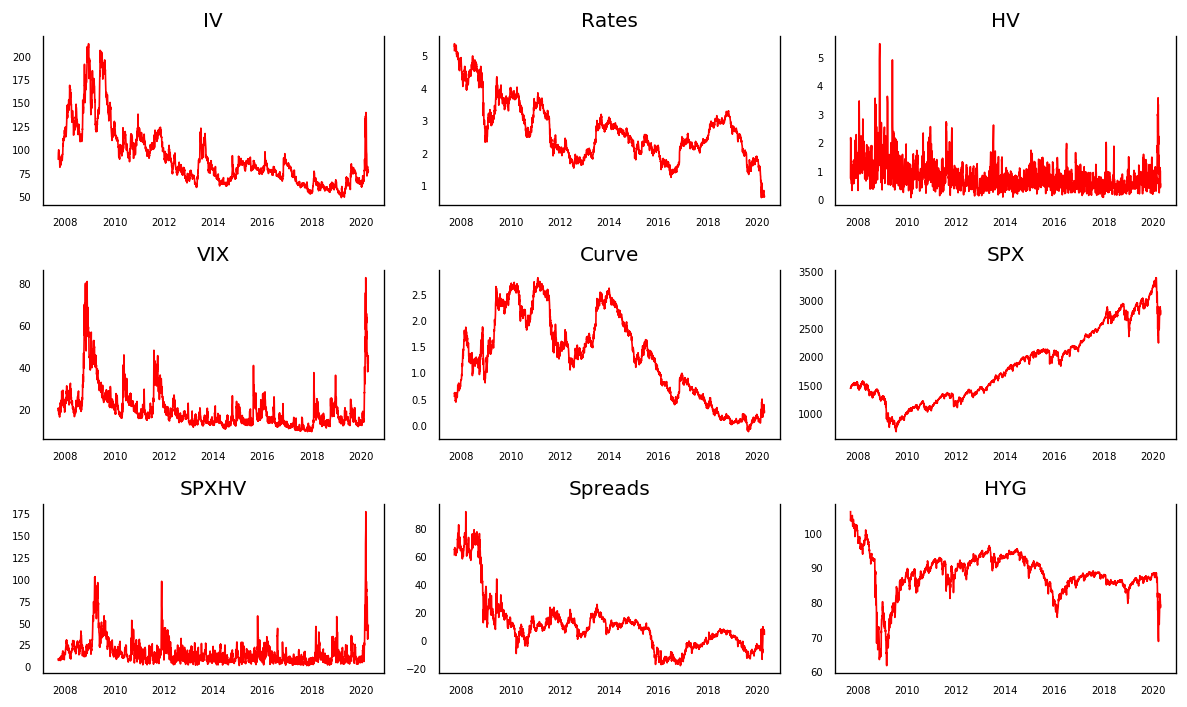

In [11]:
fig, axes = plt.subplots(nrows=3, ncols=3, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)
    
plt.tight_layout()

In [12]:
df.isna().sum()

IV         0
Rates      0
HV         0
VIX        0
Curve      0
SPX        0
SPXHV      0
Spreads    0
HYG        0
dtype: int64

# Run a Lag Plot on the Raw Data

In [13]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns = df.columns)

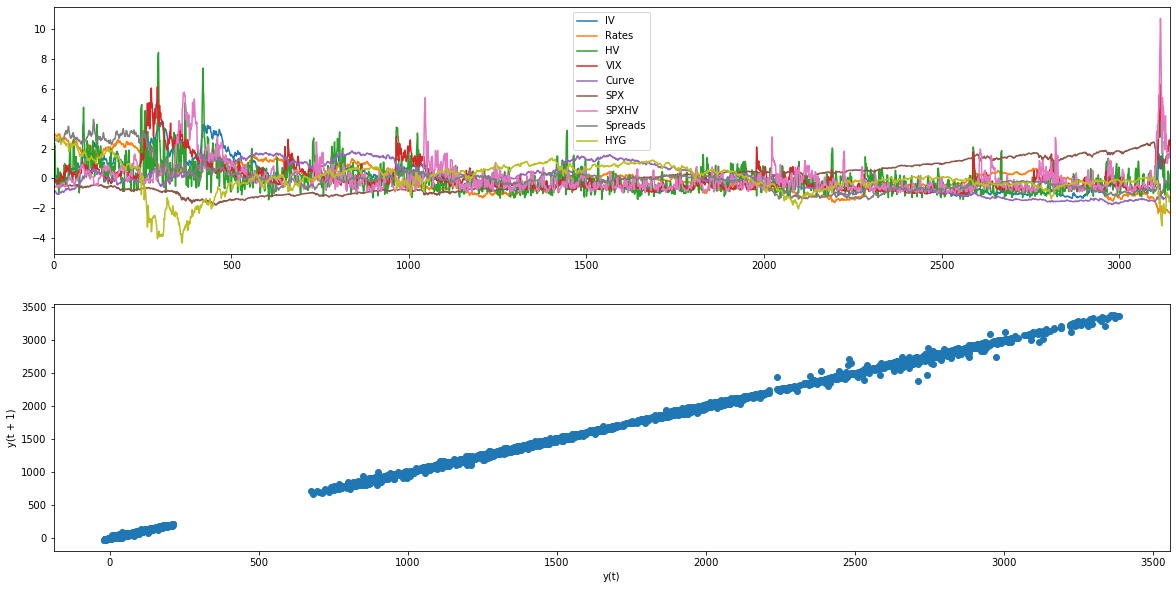

In [14]:
# Is the data Random.  Random data will not exhibit a structure in the lag plot

fig,(ax1,ax2)=plt.subplots(nrows=2, ncols=1, figsize=(20,10))
df_scaled.plot(ax=ax1) # series plot
pd.plotting.lag_plot(df) #lag plot

# Run Autocorrelation Plots on each of the Raw Variables for All Days in the Time Series

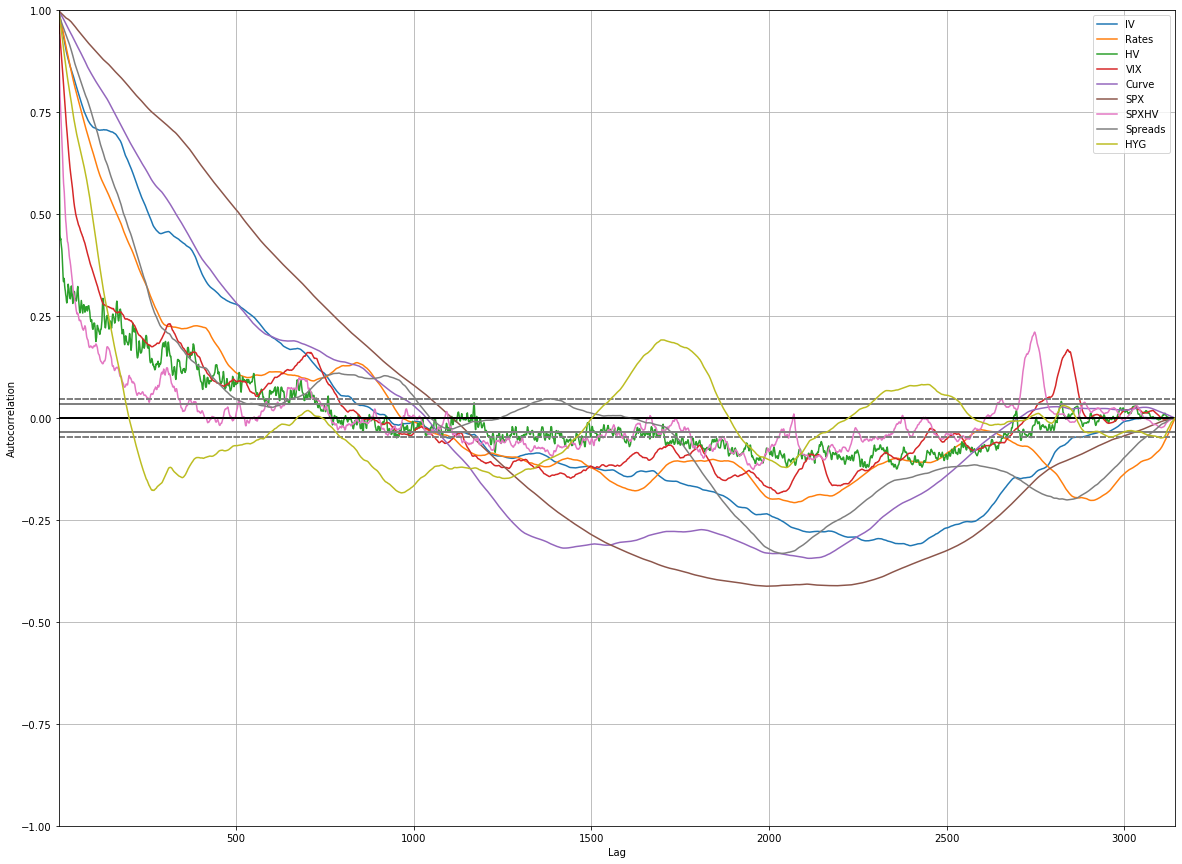

In [15]:
plt.rcParams["figure.figsize"] = (20,15)
pd.plotting.autocorrelation_plot(df.IV, label = 'IV')
pd.plotting.autocorrelation_plot(df.Rates, label = 'Rates')
pd.plotting.autocorrelation_plot(df.HV, label = 'HV')
pd.plotting.autocorrelation_plot(df.VIX, label = 'VIX')
pd.plotting.autocorrelation_plot(df.Curve, label = 'Curve')
pd.plotting.autocorrelation_plot(df.SPX, label = 'SPX')
pd.plotting.autocorrelation_plot(df.SPXHV, label = 'SPXHV')
pd.plotting.autocorrelation_plot(df.Spreads, label = 'Spreads')
pd.plotting.autocorrelation_plot(df.HYG, label = 'HYG')

# Run Autocorrelation and PACF plots for each raw variable for 75 days

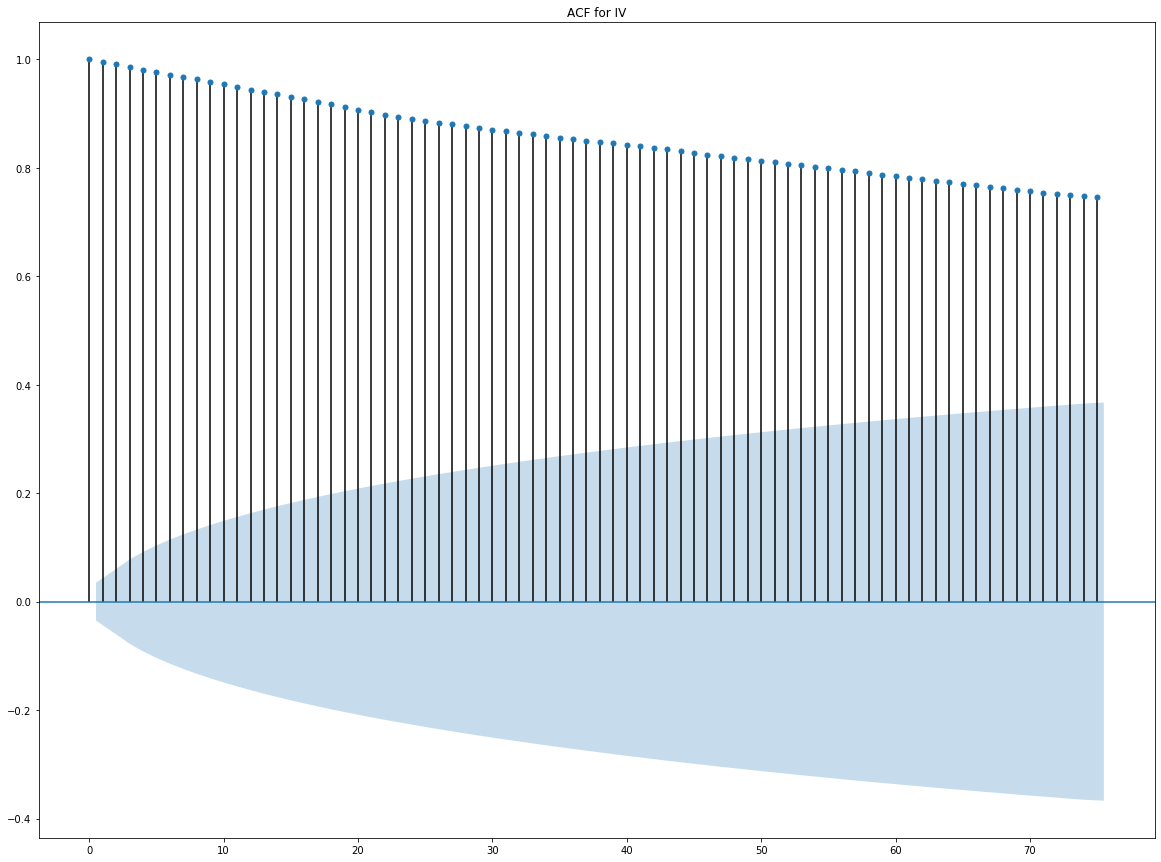

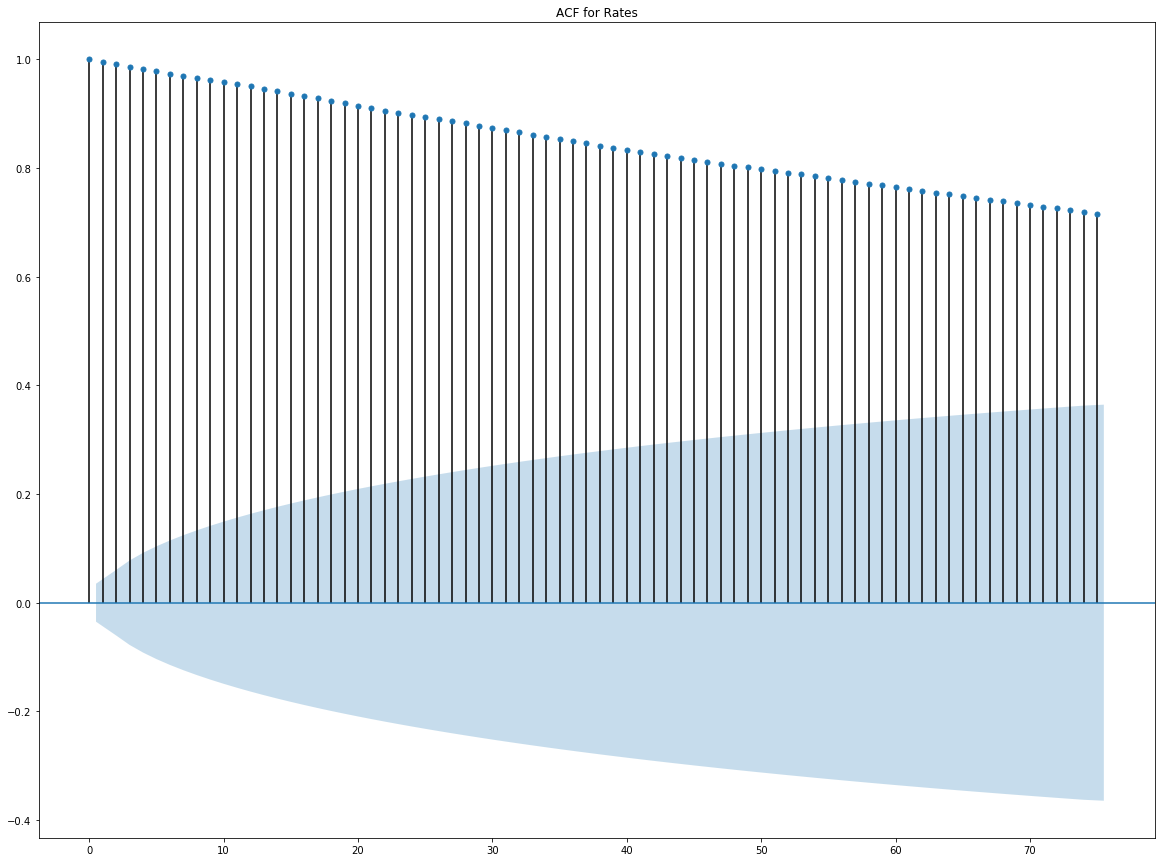

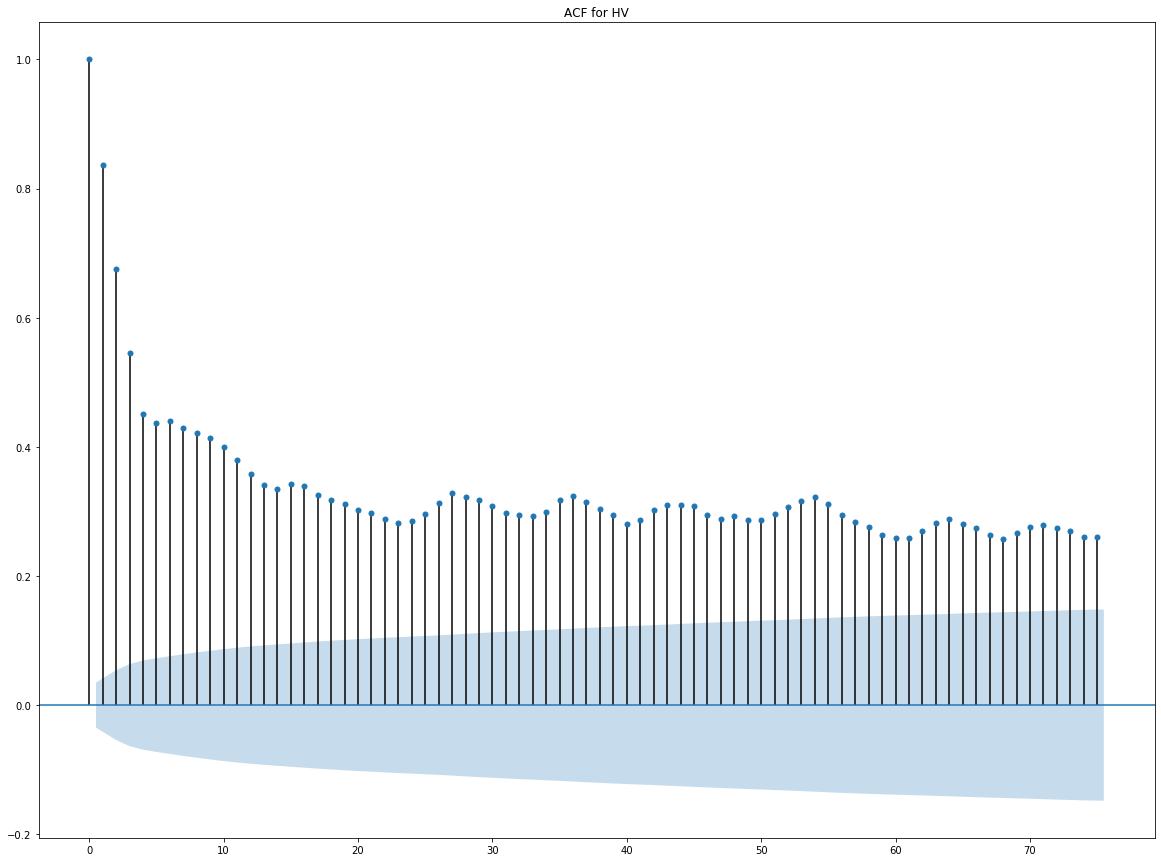

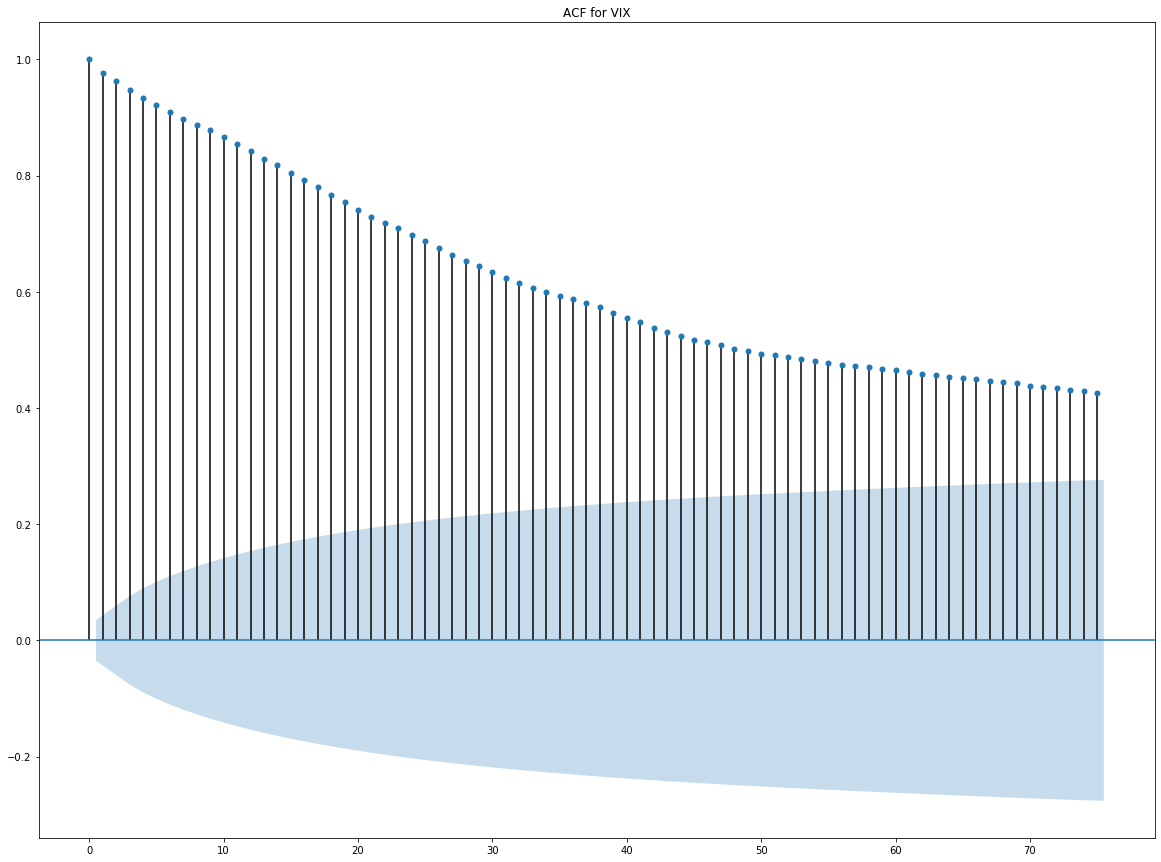

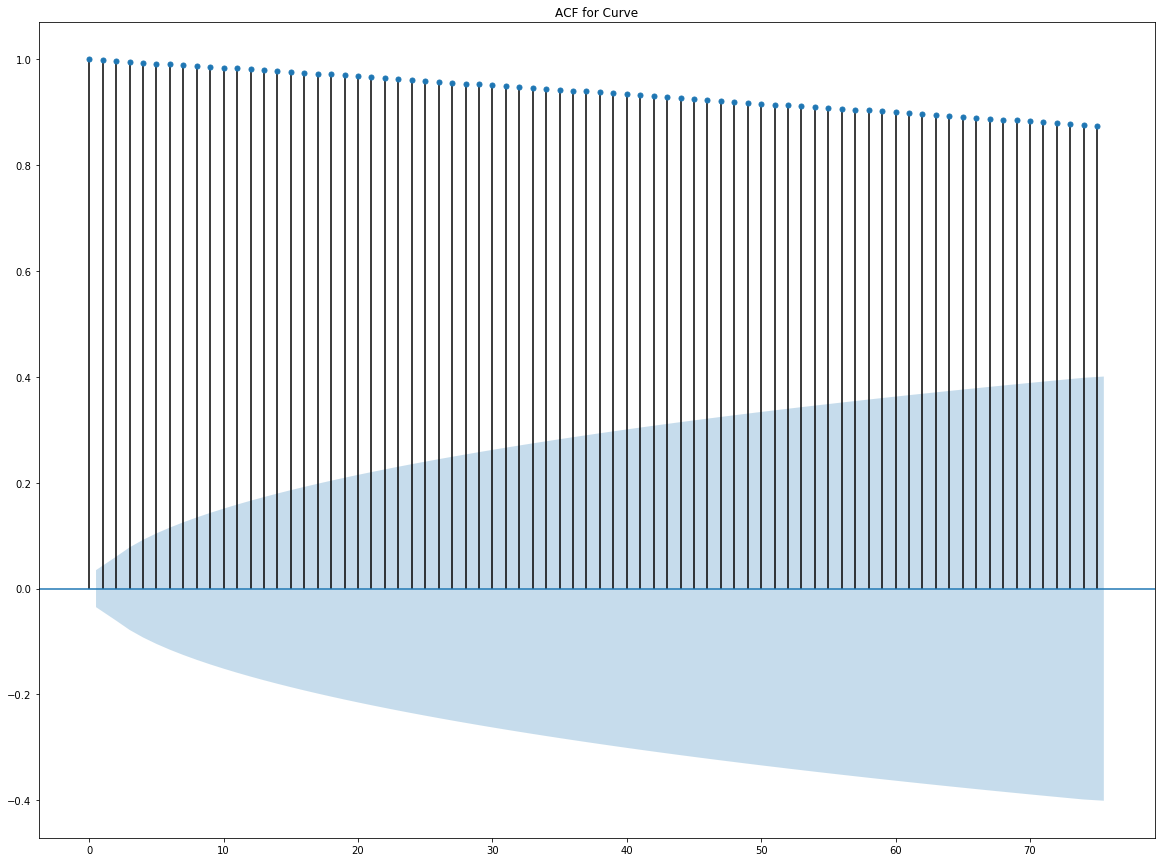

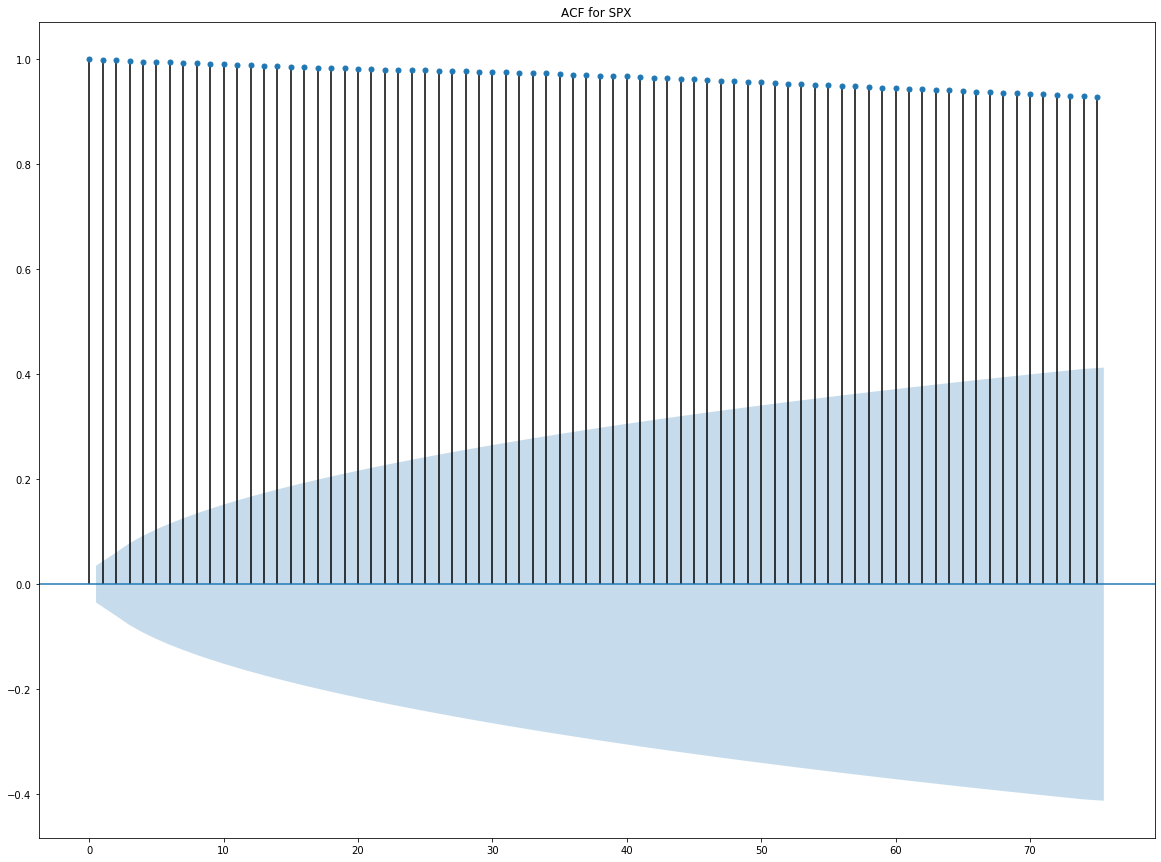

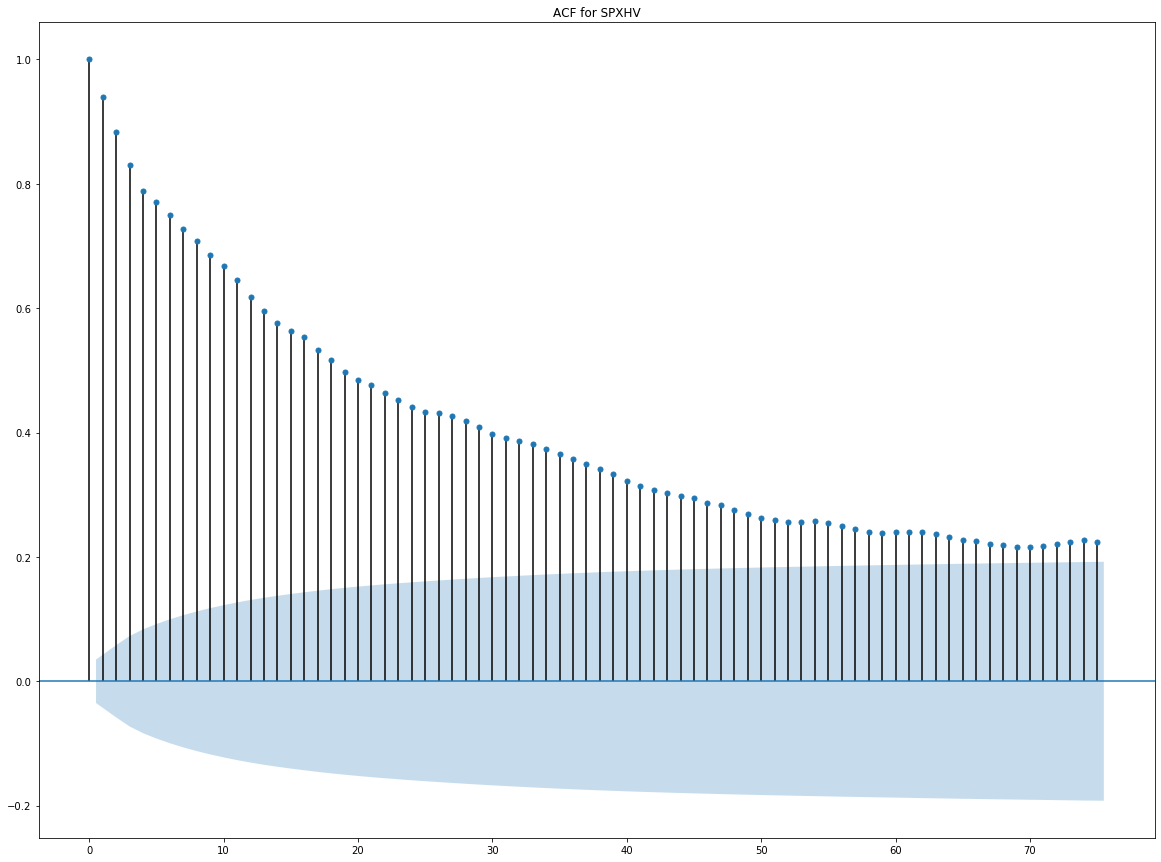

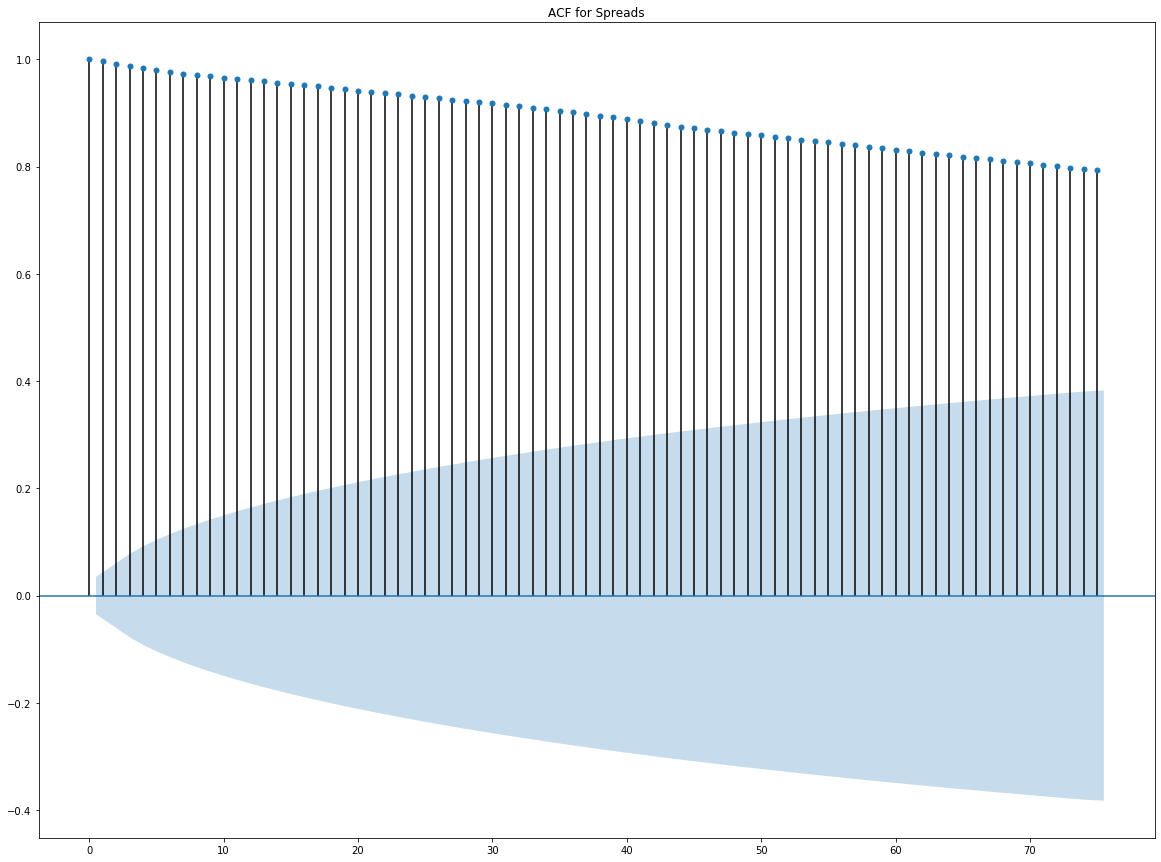

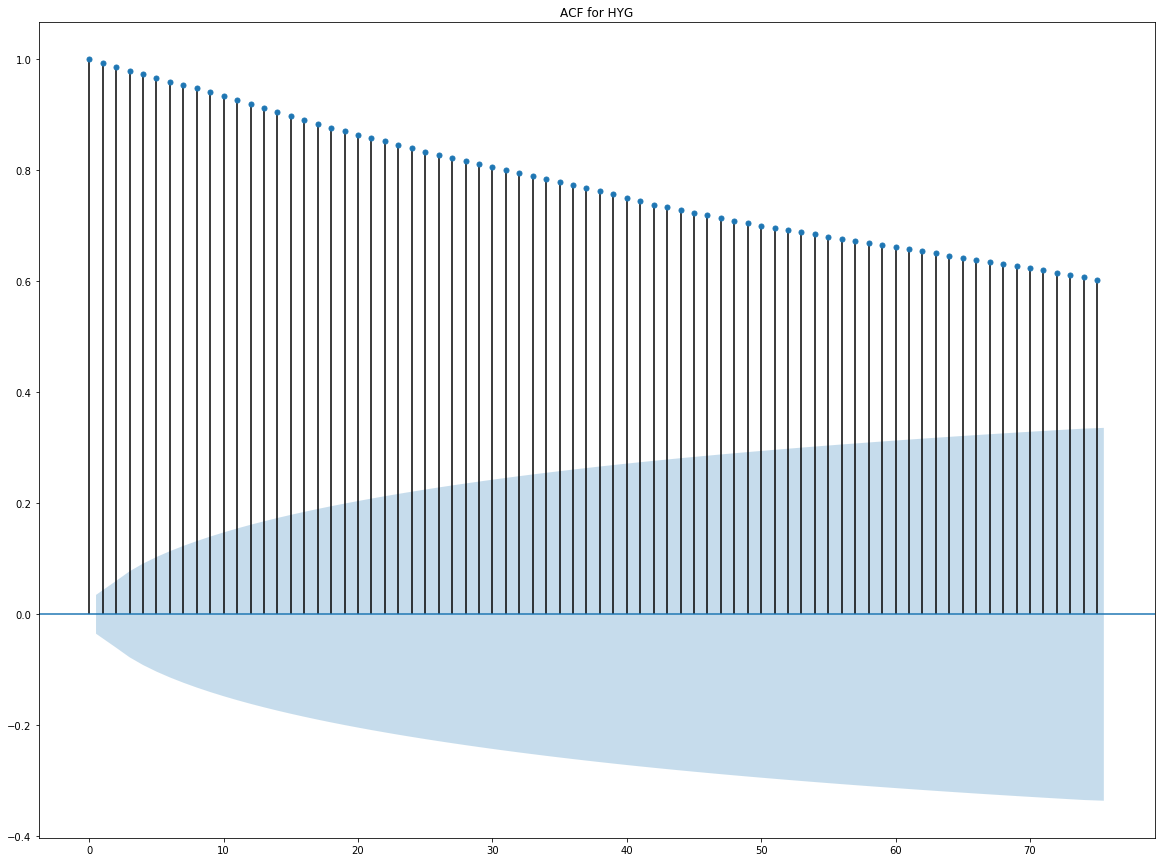

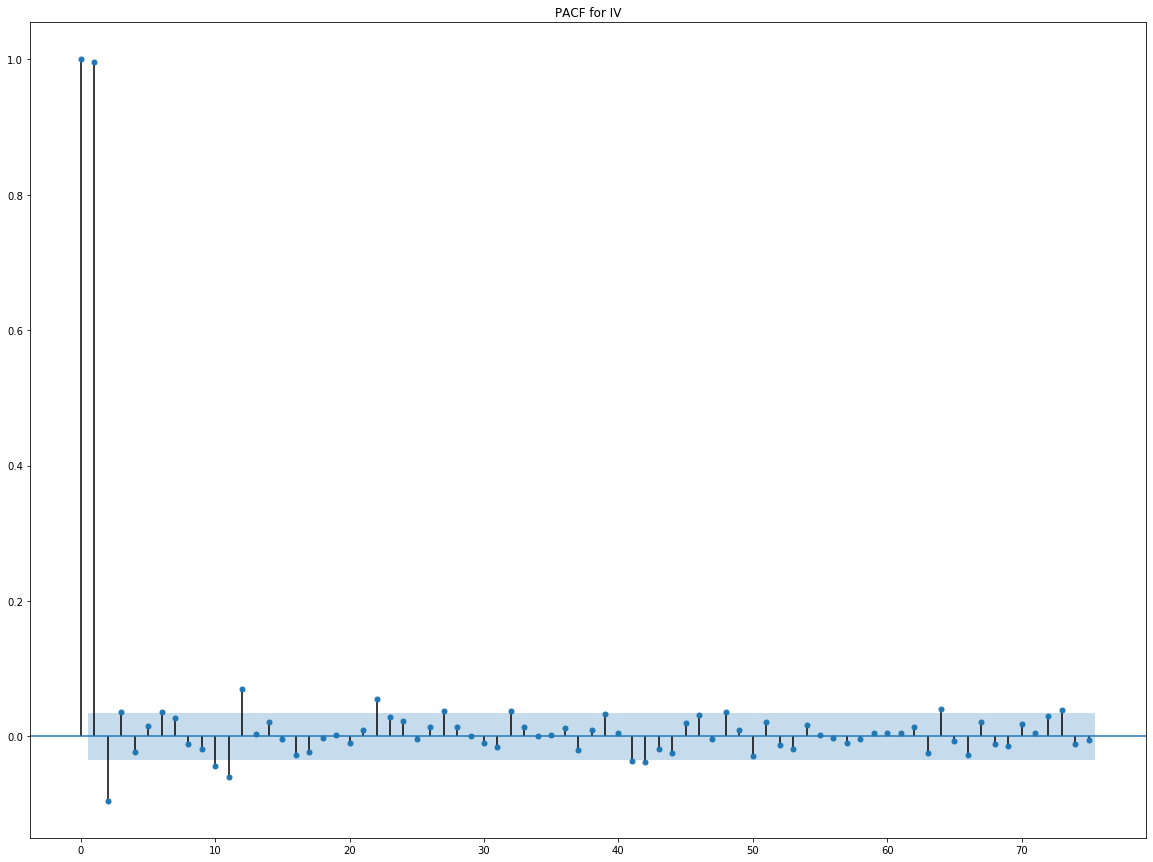

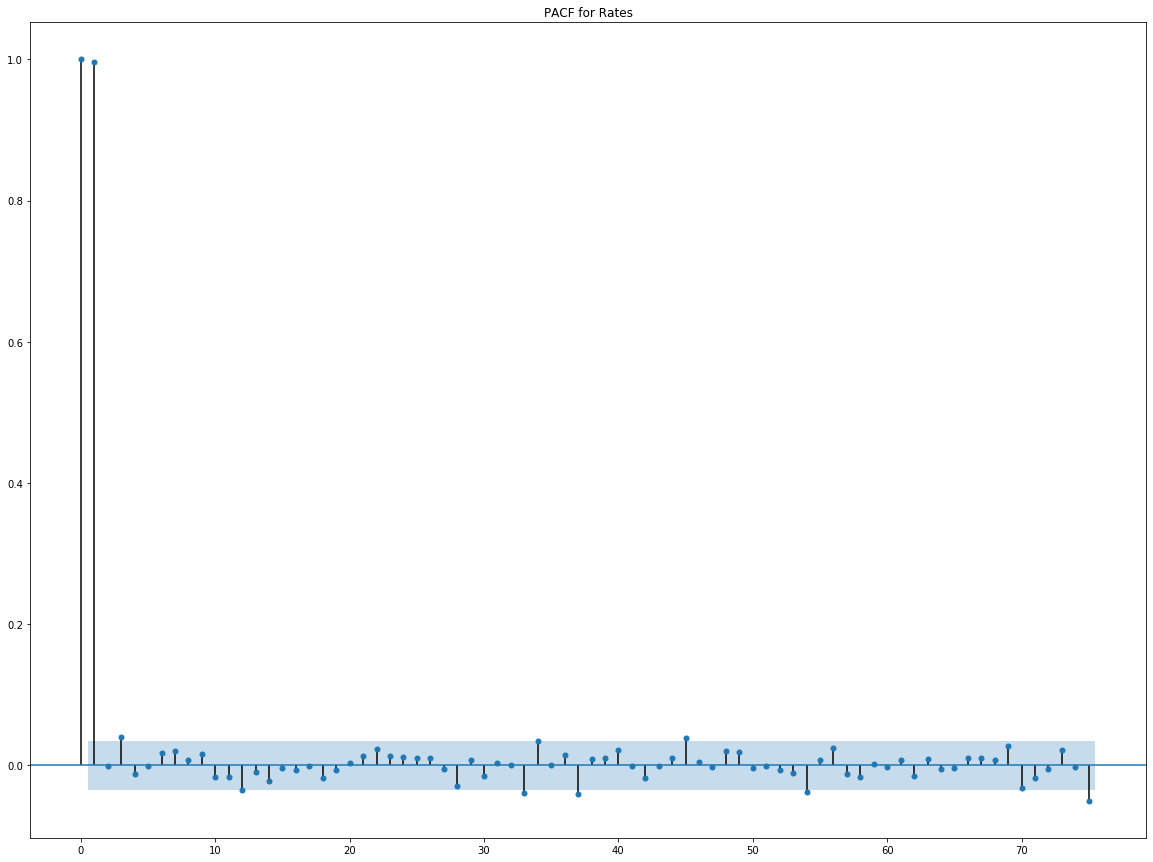

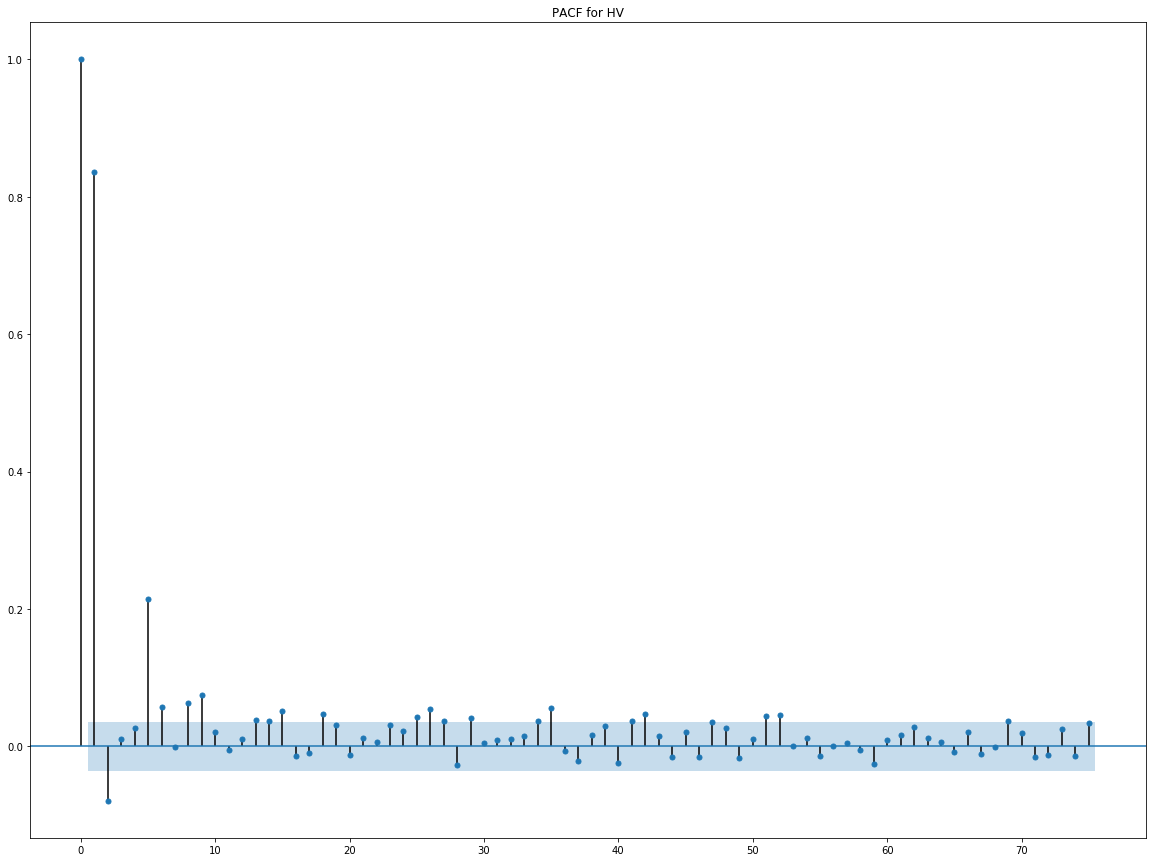

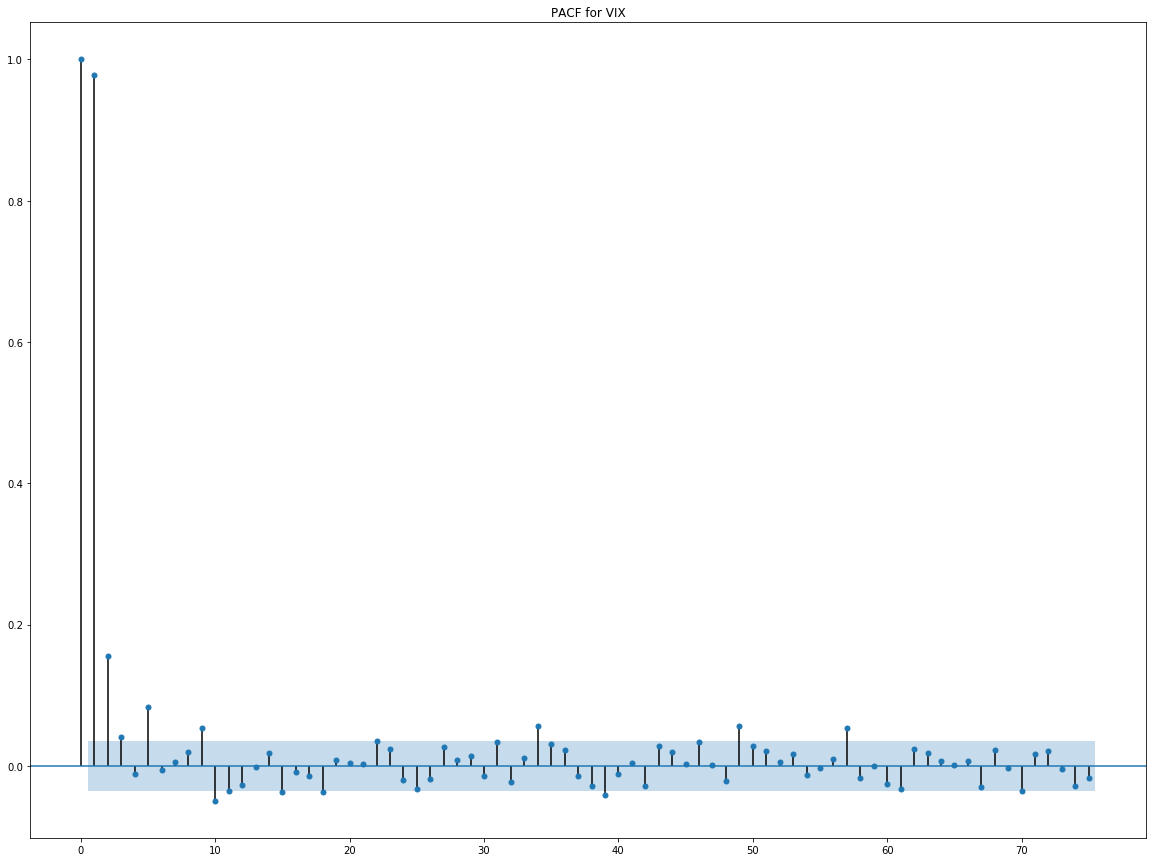

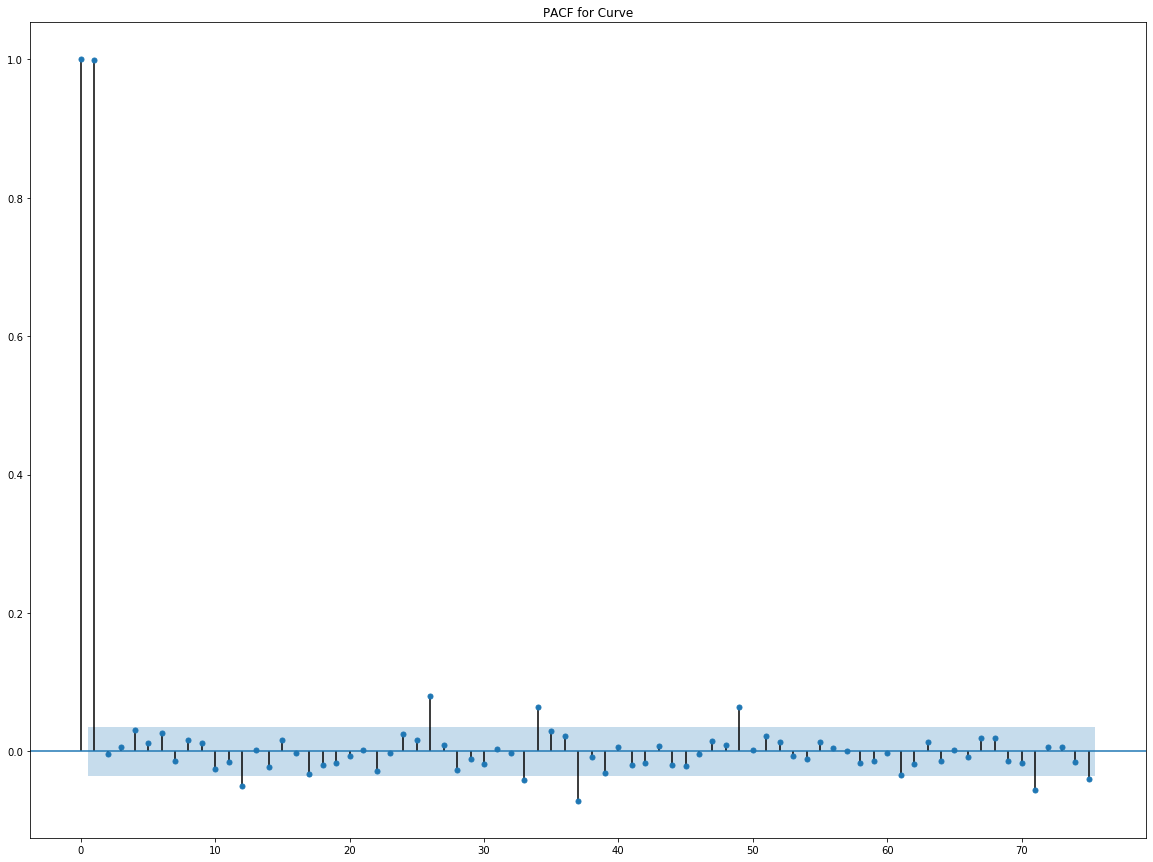

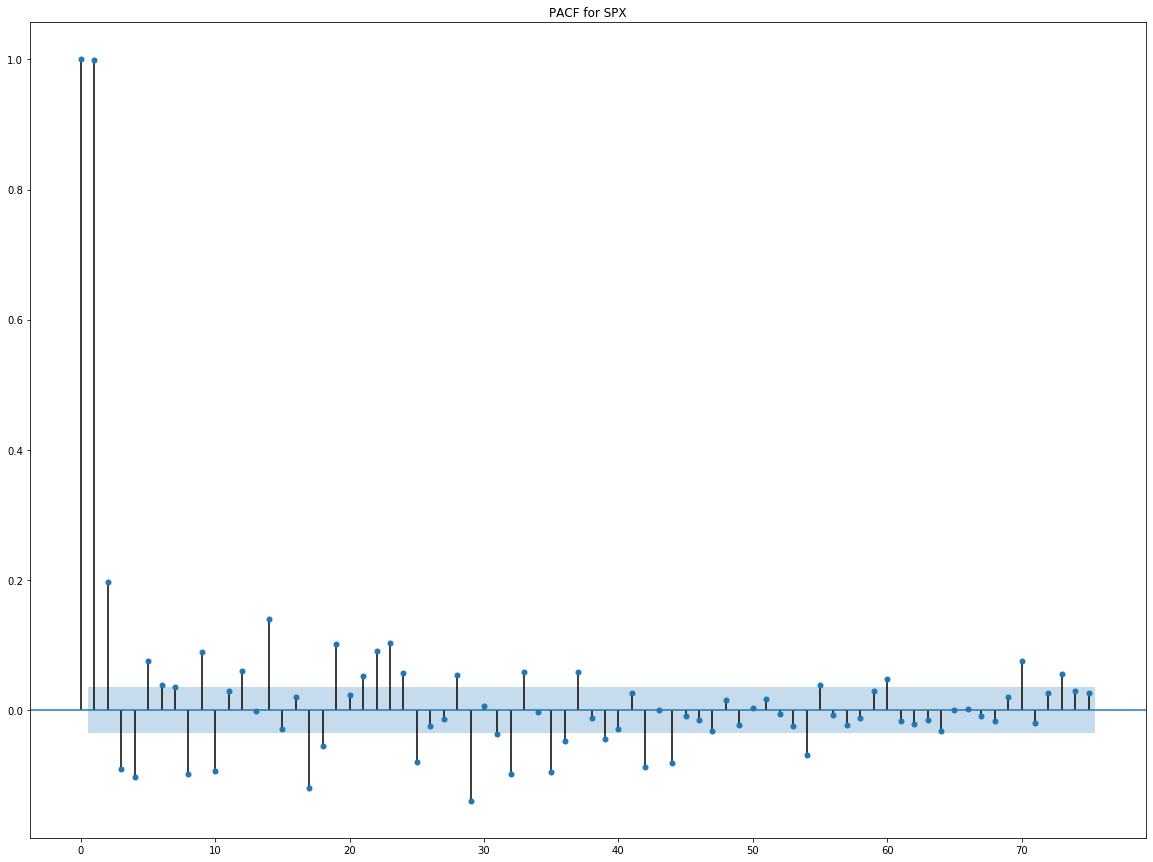

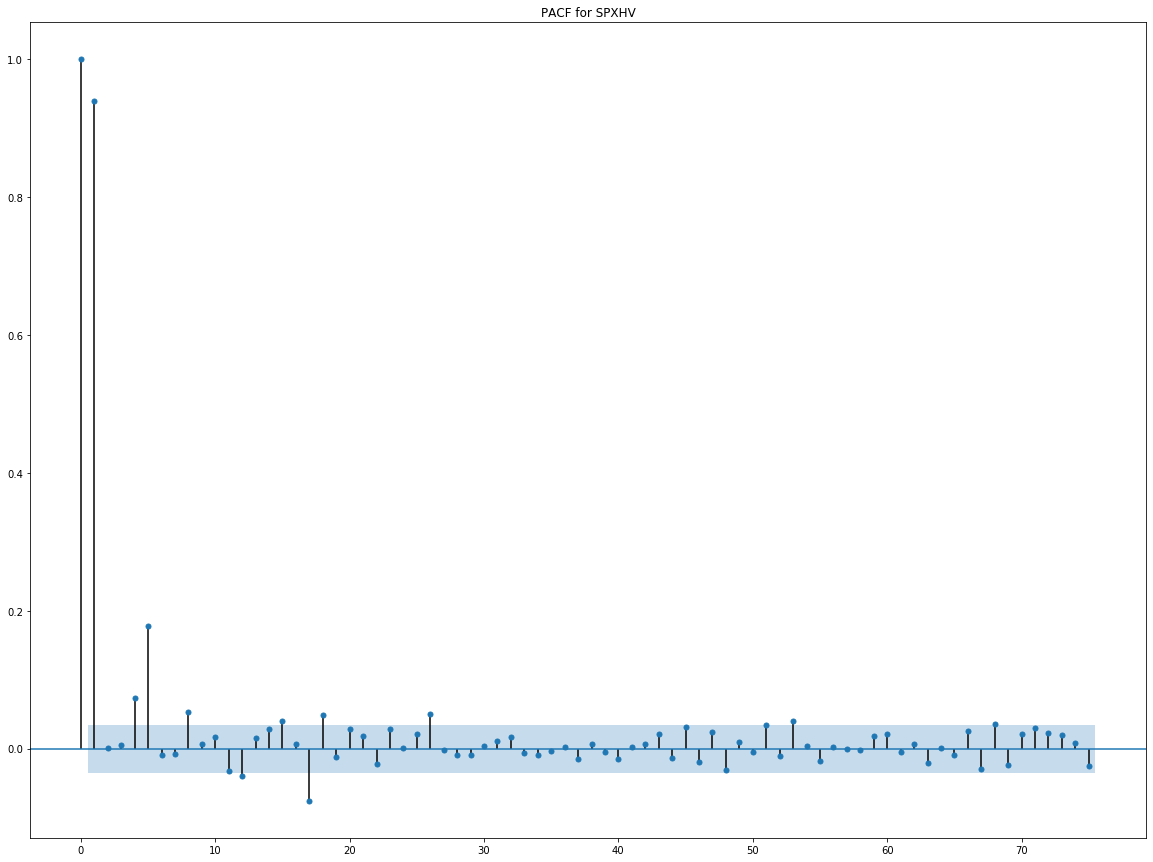

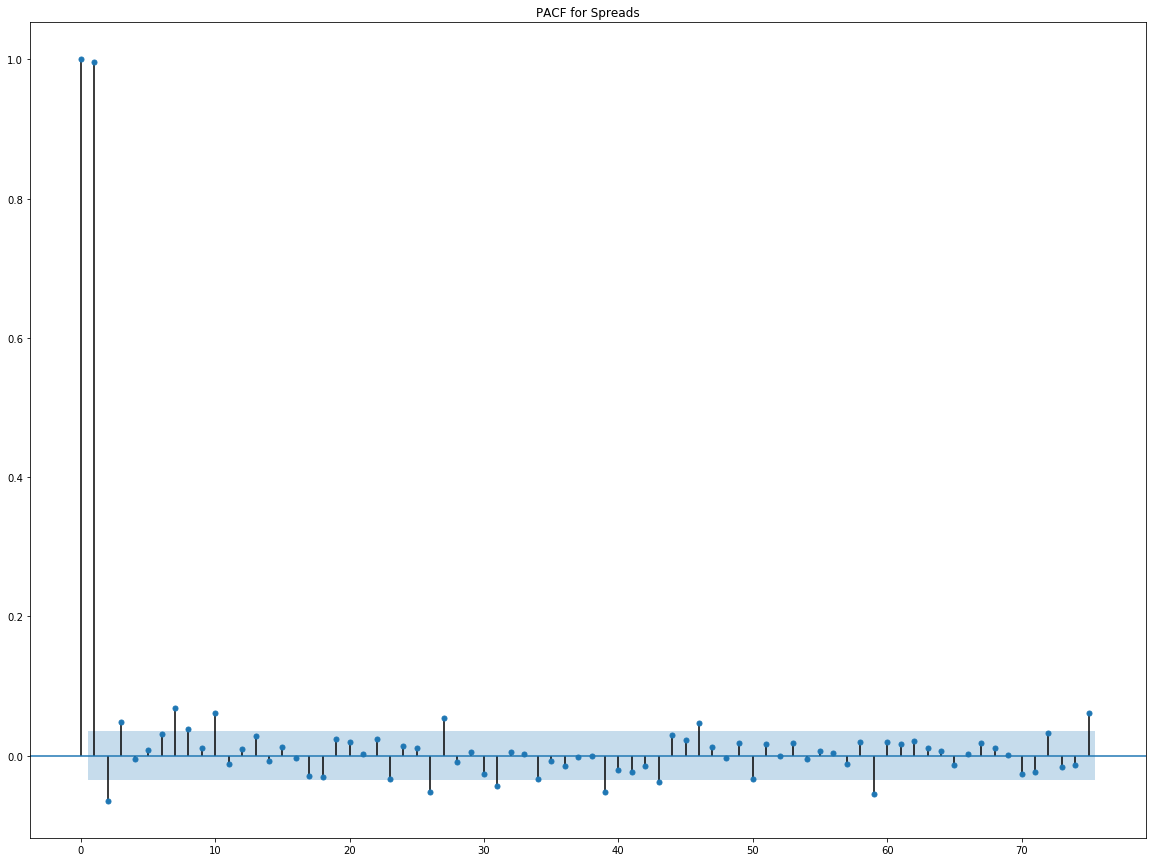

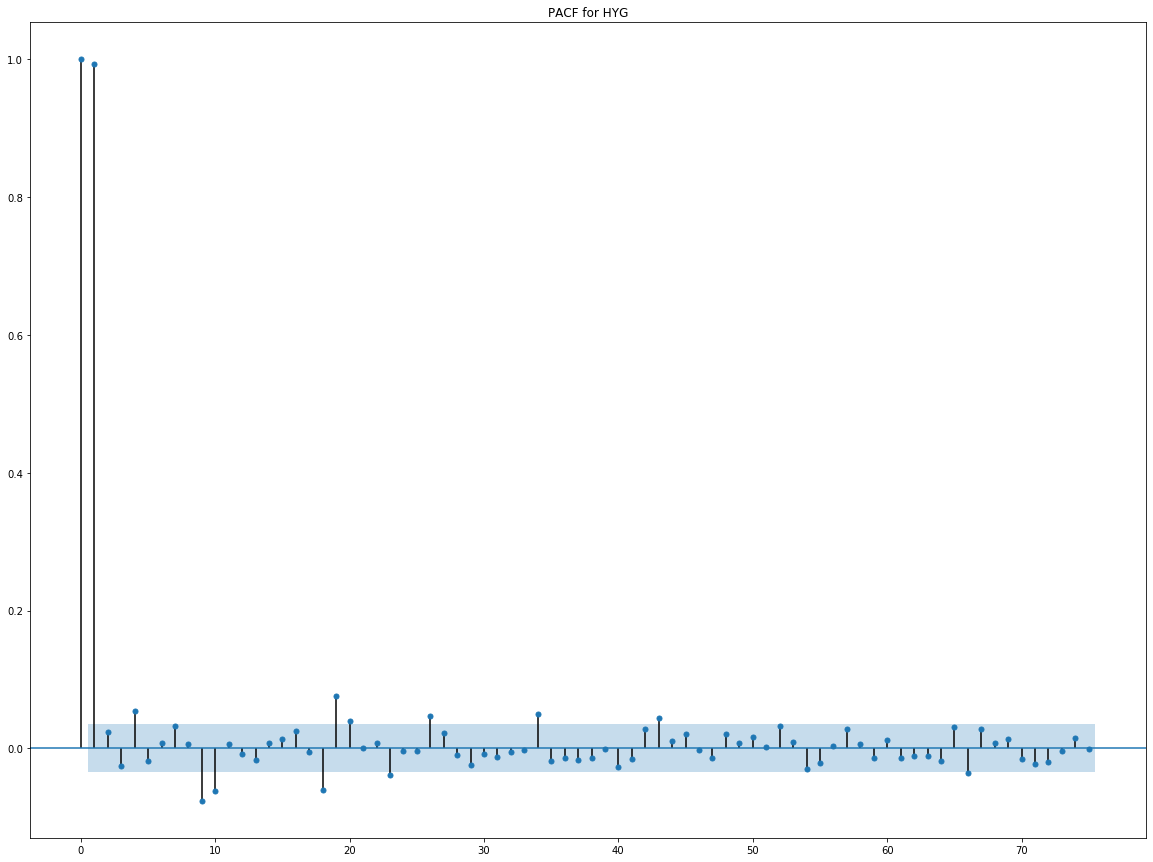

In [16]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

for i in df:
    plot_acf(df[i],lags=75)
    plt.title('ACF for %s'%i)
    
for j in df:
    plot_pacf(df[j], lags=75)
    plt.title('PACF for %s'%j)

# Run Granger Causality Tests on Every Raw Variable

The below block of code creates a function called 'grangers_causation_matrix', which runs each pair of columns against each other, n=maxlag times, and stores the minimum p-value for the given 'test' in a new 'column-by-column' dimension matrix

In [17]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df_granger = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df_granger.columns:
        for r in df_granger.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df_granger.loc[r, c] = min_p_value
    df_granger.columns = [var + '_x' for var in variables]
    df_granger.index = [var + '_y' for var in variables]
    return df_granger

grangers_causation_matrix(df, variables = df.columns)

# ran the block of code in detail - the below warning shows up (after making both of the above "verbose=True") at
# maxlag=10 for r='Spreads' and c='Spreads'

C:\Users\pjant\Miniconda3\envs\data601\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 6, but rank is 1
  'rank is %d' % (J, J_), ValueWarning)


,IV_x,Rates_x,HV_x,VIX_x,Curve_x,SPX_x,SPXHV_x,Spreads_x,HYG_x
IV_y,1.0,0.0000,0.0001,0.0000,0.0231,0.2664,0.0000,0.0008,0.0000
Rates_y,0.0,1.0000,0.0005,0.0000,0.0017,0.0086,0.1333,0.0099,0.0108
HV_y,0.0,0.0000,1.0000,0.0000,0.0002,0.0000,0.0000,0.0000,0.0000
VIX_y,0.0,0.0015,0.0003,1.0000,0.0003,0.0000,0.0000,0.0000,0.0000
Curve_y,0.0,0.0117,0.0227,0.0022,1.0000,0.0001,0.0048,0.0003,0.0911
SPX_y,0.0,0.0868,0.0000,0.0000,0.0856,1.0000,0.0000,0.0016,0.0036
SPXHV_y,0.0,0.2470,0.0000,0.0000,0.4356,0.0000,1.0000,0.0209,0.0000
Spreads_y,0.0,0.0000,0.0012,0.0000,0.0003,0.0000,0.0011,1.0000,0.0000
HYG_y,0.0,0.1091,0.0001,0.0000,0.0013,0.0000,0.0013,0.0000,1.0000


Below code block is simply a copy and detailed explanation of each line of code for the 'grangers_causation_matrix' function created above

In [18]:
maxlag=12
test = 'ssr_chi2test'
variables = df.columns
verbose=False

#first, create a 'variable'-by-'variable' size dataframe filled with 0 values, with column names 'variables', 
# and indexes 'variables'
df_granger = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)

#run a granger causality test on each column v. each column in the original dataframe, and fill the above dataframe
#with the results
for c in df_granger.columns:  # for each column
    for r in df_granger.index: # begin with, and continue through, each row
        test_result = grangercausalitytests(df[[r, c]], maxlag=maxlag, verbose=False) #calculating the GCT - r is a column, and c is a different column
        p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)] #see note below for output of grangercausalitytests (here, 'test_result')
        if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
        min_p_value = np.min(p_values) #see note below
        df_granger.loc[r, c] = min_p_value #store the minimum p-value in the current r,c location of the new dataframe 
df_granger.columns = [var + '_x' for var in variables] #rename the column_heads as the x variables
df_granger.index = [var + '_y' for var in variables] #rename the row.indexes as the y variables
df_granger

#the output of the granger causality test is:
# 1) a dictionary of
# 2) n = maxlag results
# 3) each 2) above, or n, contains
# 4) 2 items
# 5) First, a dictionary of:
#   a) ssr_ftest: (1,2,3,4)
#   b) ssr_chi2test: (1,2,3)
#   c) lrtest: (1,2,3)
#   d) params_ftest
# 6) Second, 3 'results'
#   a) <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x18ea25b0198>
#   b) <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x18ea25b0668>
#   c) array([[0.,1.,0.]])
#As a result the code line above 'p_values = ...' pulls the 2nd number of the ssr_chi2test above for each of the maxlags,
#and then the 'min_p_value = ...' stores the minimum of these values for all of the maxlag runs

C:\Users\pjant\Miniconda3\envs\data601\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 6, but rank is 1
  'rank is %d' % (J, J_), ValueWarning)


,IV_x,Rates_x,HV_x,VIX_x,Curve_x,SPX_x,SPXHV_x,Spreads_x,HYG_x
IV_y,1.0,0.0000,0.0001,0.0000,0.0231,0.2664,0.0000,0.0008,0.0000
Rates_y,0.0,1.0000,0.0005,0.0000,0.0017,0.0086,0.1333,0.0099,0.0108
HV_y,0.0,0.0000,1.0000,0.0000,0.0002,0.0000,0.0000,0.0000,0.0000
VIX_y,0.0,0.0015,0.0003,1.0000,0.0003,0.0000,0.0000,0.0000,0.0000
Curve_y,0.0,0.0117,0.0227,0.0022,1.0000,0.0001,0.0048,0.0003,0.0911
SPX_y,0.0,0.0868,0.0000,0.0000,0.0856,1.0000,0.0000,0.0016,0.0036
SPXHV_y,0.0,0.2470,0.0000,0.0000,0.4356,0.0000,1.0000,0.0209,0.0000
Spreads_y,0.0,0.0000,0.0012,0.0000,0.0003,0.0000,0.0011,1.0000,0.0000
HYG_y,0.0,0.1091,0.0001,0.0000,0.0013,0.0000,0.0013,0.0000,1.0000


The 2 code blocks below are simply a way to test each of the individual results in the above matrix for correctness.  Not necessary to run, just here in case of 'suspicious' values that need to be checked.

In [19]:
granger = grangercausalitytests(df[['HYG','IV']], maxlag=12, verbose=True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9861  , p=0.3208  , df_denom=3139, df_num=1
ssr based chi2 test:   chi2=0.9871  , p=0.3205  , df=1
likelihood ratio test: chi2=0.9869  , p=0.3205  , df=1
parameter F test:         F=0.9861  , p=0.3208  , df_denom=3139, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.0697  , p=0.0172  , df_denom=3136, df_num=2
ssr based chi2 test:   chi2=8.1523  , p=0.0170  , df=2
likelihood ratio test: chi2=8.1417  , p=0.0171  , df=2
parameter F test:         F=4.0697  , p=0.0172  , df_denom=3136, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.4211  , p=0.0642  , df_denom=3133, df_num=3
ssr based chi2 test:   chi2=7.2796  , p=0.0635  , df=3
likelihood ratio test: chi2=7.2712  , p=0.0637  , df=3
parameter F test:         F=2.4211  , p=0.0642  , df_denom=3133, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.7771  , p=0.

In [20]:
a = 0
b = 1

print(granger[1][a]['ssr_chi2test'][b])
print(granger[2][a]['ssr_chi2test'][b])
print(granger[3][a]['ssr_chi2test'][b])
print(granger[4][a]['ssr_chi2test'][b])
print(granger[5][a]['ssr_chi2test'][b])
print(granger[6][a]['ssr_chi2test'][b])
print(granger[7][a]['ssr_chi2test'][b])
print(granger[8][a]['ssr_chi2test'][b])
print(granger[9][a]['ssr_chi2test'][b])
print(granger[10][a]['ssr_chi2test'][b])
print(granger[11][a]['ssr_chi2test'][b])
print(granger[12][a]['ssr_chi2test'][b])

0.32045757453187096
0.016972693613427178
0.0634994891729118
0.12923494727025536
0.08266675303919897
0.13545366412617504
0.19549613305847827
0.2337864603771952
0.37529001727382155
0.014173979861856149
2.1635234652128535e-06
2.9706117719100306e-06


# Run Cointegration Tests for Each of the Raw Variables

In [21]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
IV     ::  661.74    > 179.5199  =>   True
Rates  ::  311.56    > 143.6691  =>   True
HV     ::  175.8     > 111.7797  =>   True
VIX    ::  82.51     > 83.9383   =>   False
Curve  ::  52.54     > 60.0627   =>   False
SPX    ::  26.4      > 40.1749   =>   False
SPXHV  ::  10.19     > 24.2761   =>   False
Spreads ::  2.6       > 12.3212   =>   False
HYG    ::  0.07      > 4.1296    =>   False


# Run Dickey-Fuller Tests on the Raw Data to Check for Stationarity

In [22]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")    

In [23]:
# ADF Test on each column
for name, column in df.iteritems():      # changed this row of code - df_train to df
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "IV" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.6895
 No. Lags Chosen       = 11
 Critical value 1%     = -3.432
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0759. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "Rates" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.2568
 No. Lags Chosen       = 2
 Critical value 1%     = -3.432
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.1863. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "HV" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root

# Create Training and Testing Set on the Raw Data

In [24]:
nobs = 10
df_train, df_test = df[0:-nobs], df[-nobs:]

# Check size
print(df_train.shape)
print(df_test.shape)

(3133, 9)
(10, 9)


# Difference the Training Data (ADF Tests Did Not Look Good; also too much AC)

In [25]:
t = df_train.diff().dropna()

# Analyze the Differenced Data

In [26]:
t.head()

,IV,Rates,HV,VIX,Curve,SPX,SPXHV,Spreads,HYG
Date,,,,,,,,,
2007-09-20,5.35,0.2075,1.054968,0.42,0.0640,3.78,-1.027256,4.02,-2.60
2007-09-21,1.20,-0.0915,0.358402,-1.45,-0.0095,-9.52,-0.571470,-0.45,0.26
2007-09-24,2.25,0.0230,-0.169979,0.37,-0.0090,8.93,0.357951,1.01,0.70
2007-09-25,1.00,-0.0015,0.033081,-0.77,0.0095,5.05,-0.227487,0.49,0.25
2007-09-26,-1.10,-0.0185,-1.228518,-0.97,0.0130,15.62,1.289694,-1.30,-0.38


In [27]:
t.corr()

,IV,Rates,HV,VIX,Curve,SPX,SPXHV,Spreads,HYG
IV,1.000000,0.152961,0.108123,0.238946,0.167995,-0.095689,-0.037881,0.178660,-0.206556
Rates,0.152961,1.000000,0.017341,-0.370781,0.674631,0.109263,-0.005226,0.217350,0.255032
HV,0.108123,0.017341,1.000000,0.020994,0.059763,-0.006630,0.001226,0.044743,-0.031907
VIX,0.238946,-0.370781,0.020994,1.000000,-0.255592,-0.195725,0.040175,0.100634,-0.580236
Curve,0.167995,0.674631,0.059763,-0.255592,1.000000,0.067724,0.010792,0.088893,0.193401
SPX,-0.095689,0.109263,-0.006630,-0.195725,0.067724,1.000000,0.019678,-0.024647,0.178370
SPXHV,-0.037881,-0.005226,0.001226,0.040175,0.010792,0.019678,1.000000,-0.046822,0.025721
Spreads,0.178660,0.217350,0.044743,0.100634,0.088893,-0.024647,-0.046822,1.000000,-0.079894
HYG,-0.206556,0.255032,-0.031907,-0.580236,0.193401,0.178370,0.025721,-0.079894,1.000000


In [28]:
t.describe()

,IV,Rates,HV,VIX,Curve,SPX,SPXHV,Spreads,HYG
count,3132.000000,3132.000000,3132.000000,3132.000000,3132.000000,3132.000000,3132.000000,3132.000000,3132.000000
mean,-0.002730,-0.001381,-0.000075,0.007446,-0.000073,0.416785,0.016546,-0.017692,-0.009192
std,2.925084,0.061896,0.313713,2.072119,0.040692,23.169810,5.166030,1.521523,0.620639
min,-20.150000,-0.441000,-2.774537,-17.640000,-0.322000,-324.890000,-45.733687,-13.500000,-6.980000
25%,-1.240000,-0.036925,-0.113314,-0.762500,-0.021425,-7.030000,-1.454745,-0.570000,-0.200000
50%,-0.105000,-0.001900,0.002491,-0.095000,-0.001500,1.125000,0.008535,0.000000,0.017500
75%,1.086700,0.034200,0.115582,0.590000,0.021000,9.555000,1.585843,0.550000,0.210000
max,32.180000,0.342500,2.558241,24.860000,0.254500,230.380000,55.719395,13.500000,8.365000


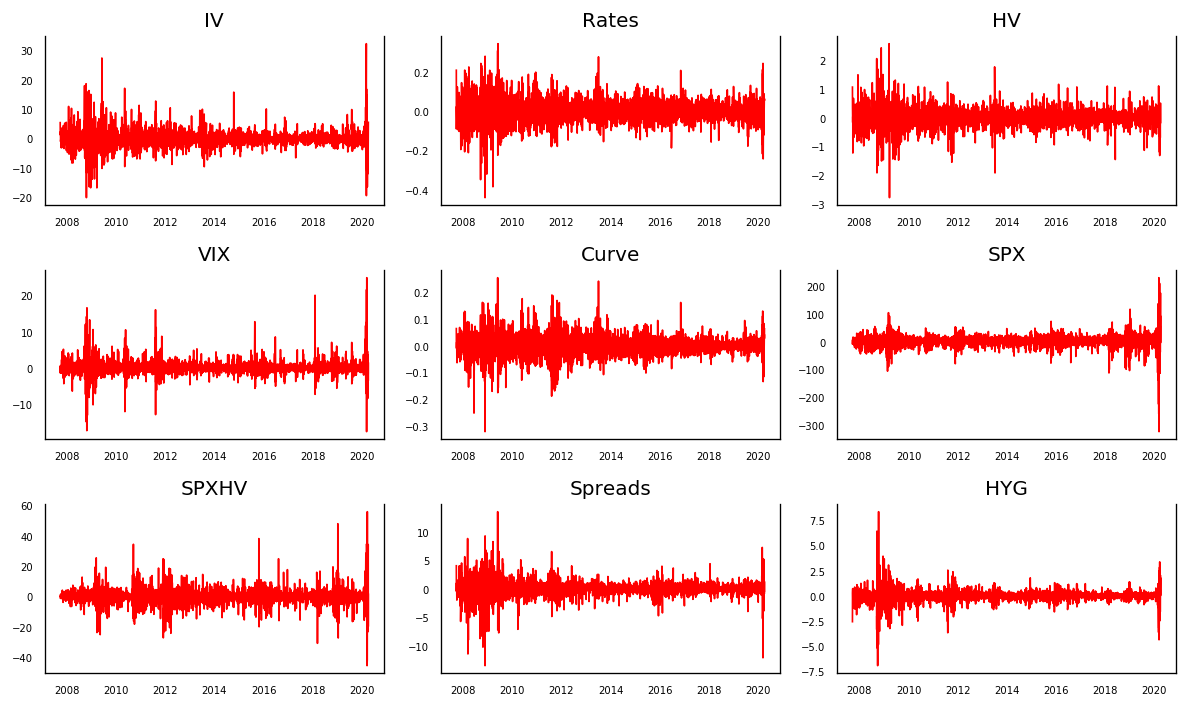

In [29]:
fig, axes = plt.subplots(nrows=3, ncols=3, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = t[t.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    ax.set_title(t.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)
    
plt.tight_layout()

# Run a Lag Plot on the Differenced Data

In [30]:
t_scaled = pd.DataFrame(scaler.fit_transform(t), columns = t.columns)

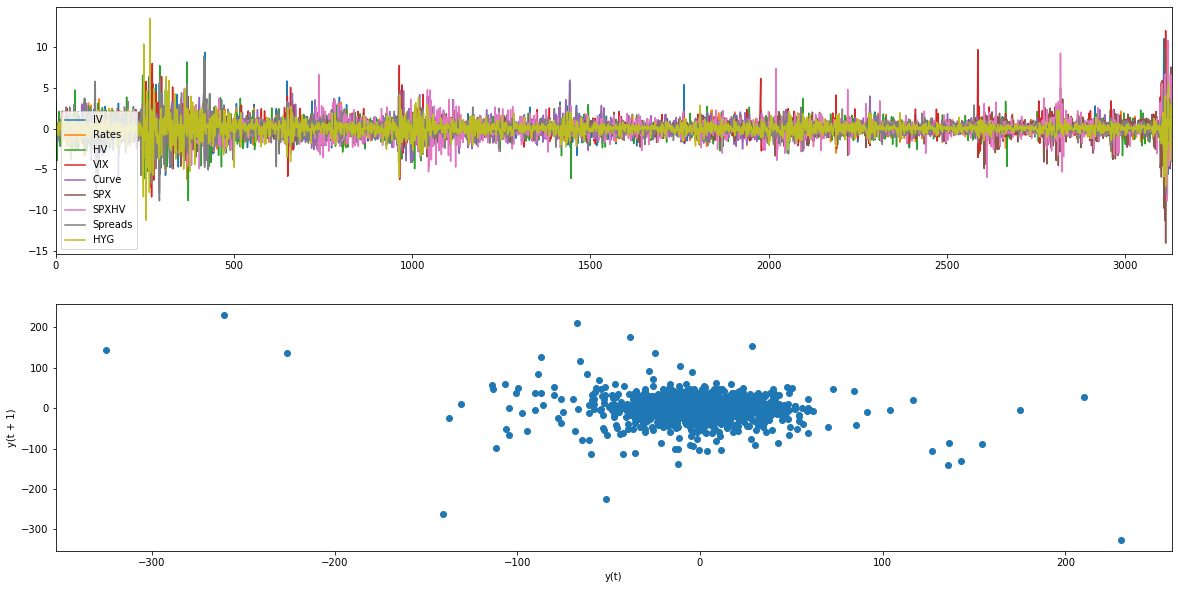

In [31]:
# Is the data Random.  Random data will not exhibit a structure in the lag plot

fig,(ax1,ax2)=plt.subplots(nrows=2, ncols=1, figsize=(20,10))
t_scaled.plot(ax=ax1) # series plot
pd.plotting.lag_plot(t) #lag plot

# Run Autocorrelation Plots on each of the Differenced Variables for All Days in the Time Series

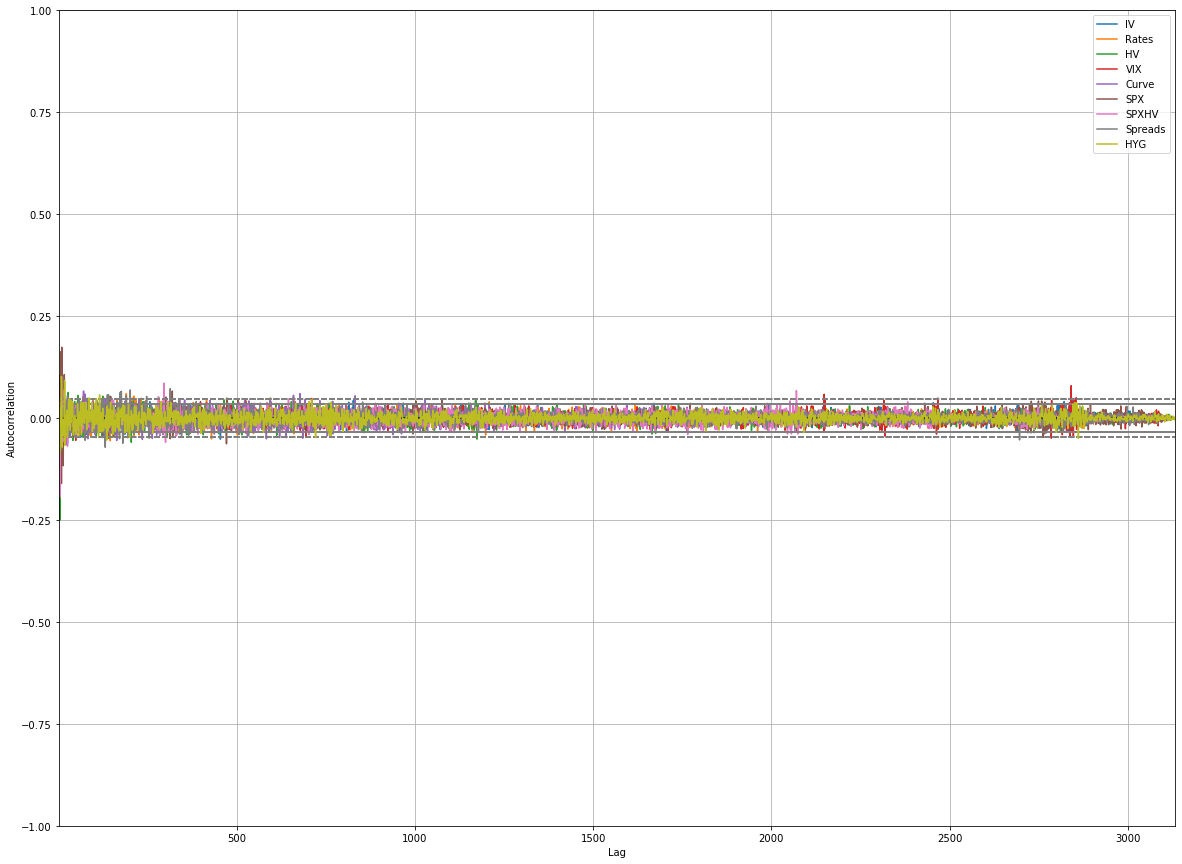

In [32]:
pd.plotting.autocorrelation_plot(t.IV, label = 'IV')
pd.plotting.autocorrelation_plot(t.Rates, label = 'Rates')
pd.plotting.autocorrelation_plot(t.HV, label = 'HV')
pd.plotting.autocorrelation_plot(t.VIX, label = 'VIX')
pd.plotting.autocorrelation_plot(t.Curve, label = 'Curve')
pd.plotting.autocorrelation_plot(t.SPX, label = 'SPX')
pd.plotting.autocorrelation_plot(t.SPXHV, label = 'SPXHV')
pd.plotting.autocorrelation_plot(t.Spreads, label = 'Spreads')
pd.plotting.autocorrelation_plot(t.HYG, label = 'HYG')
plt.rcParams["figure.figsize"] = (20,15)

# Run Autocorrelation and PACF plots for each differenced variable for 75 days

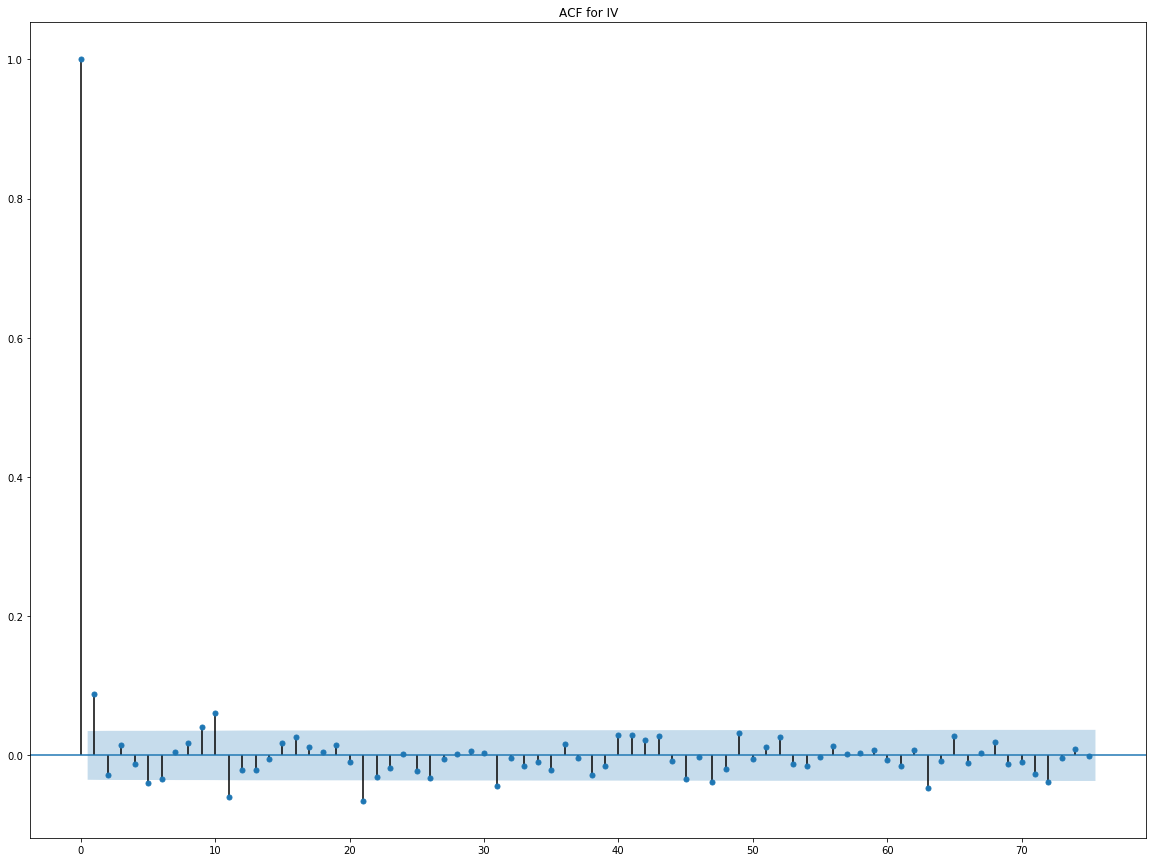

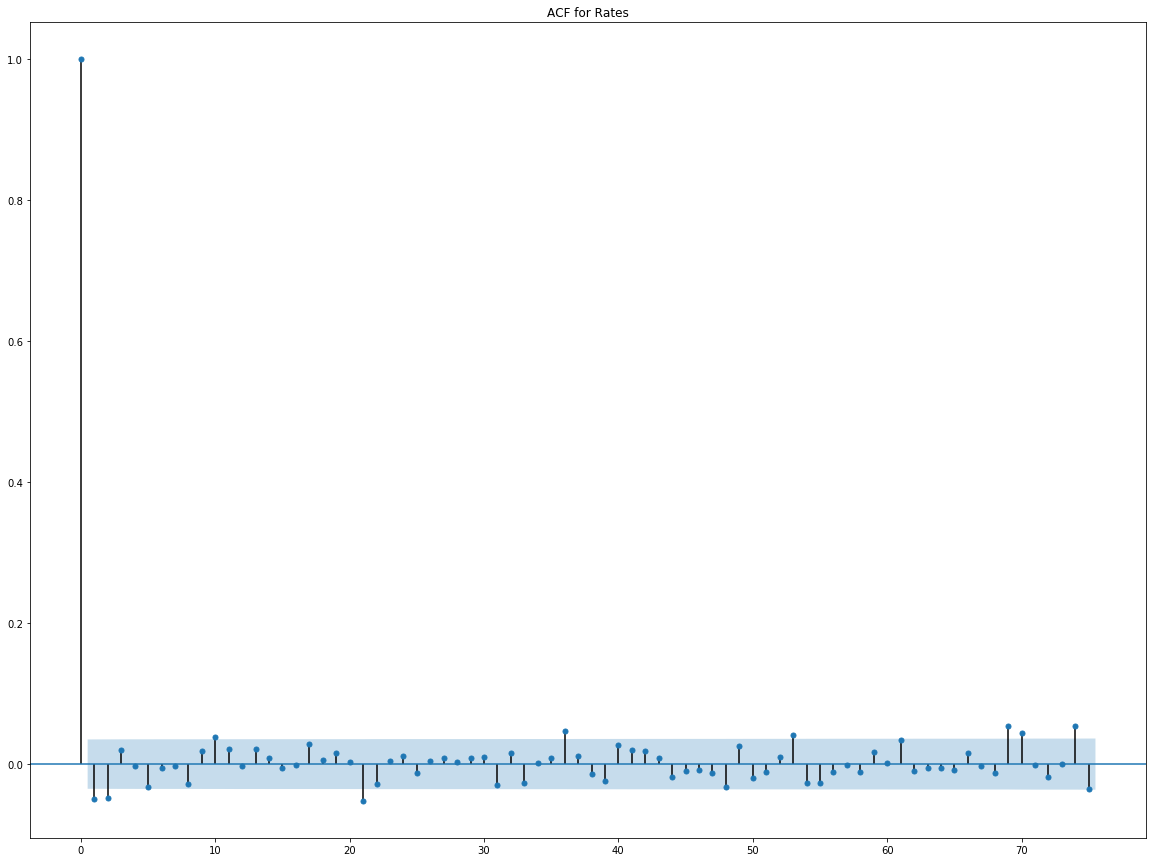

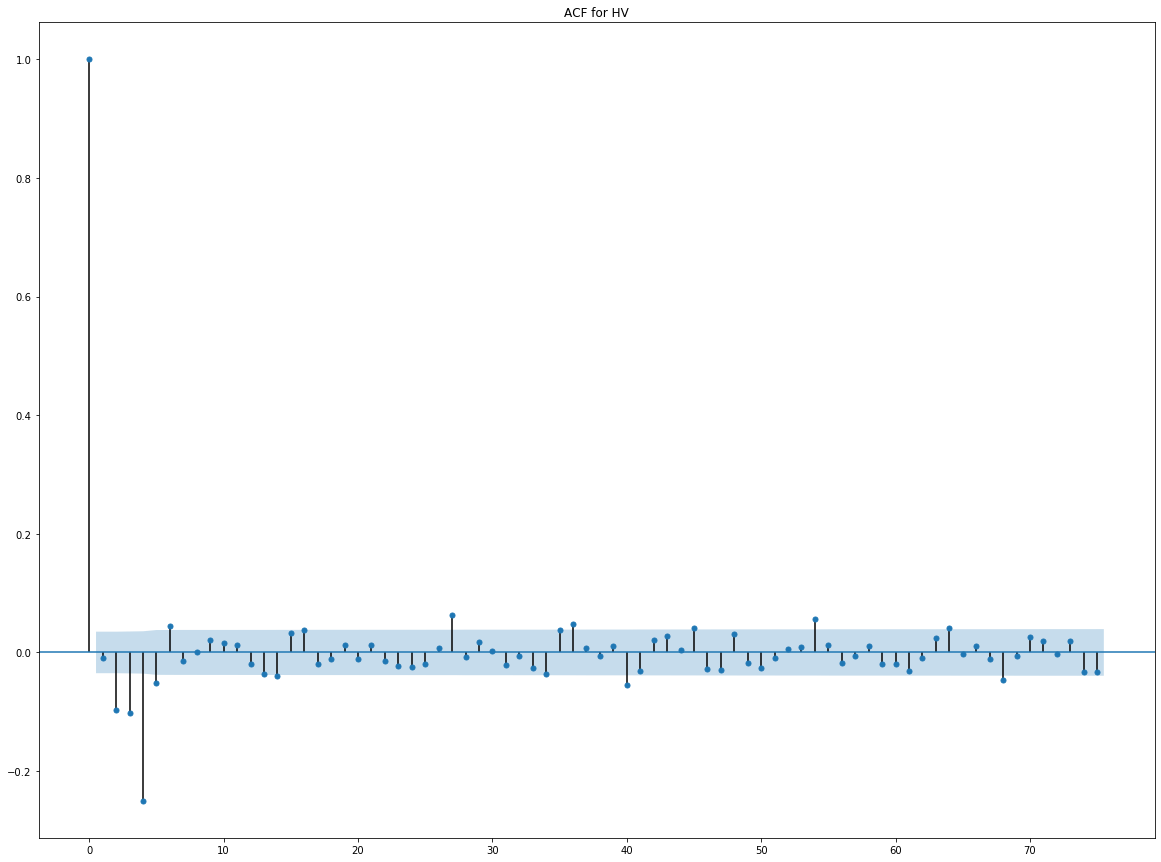

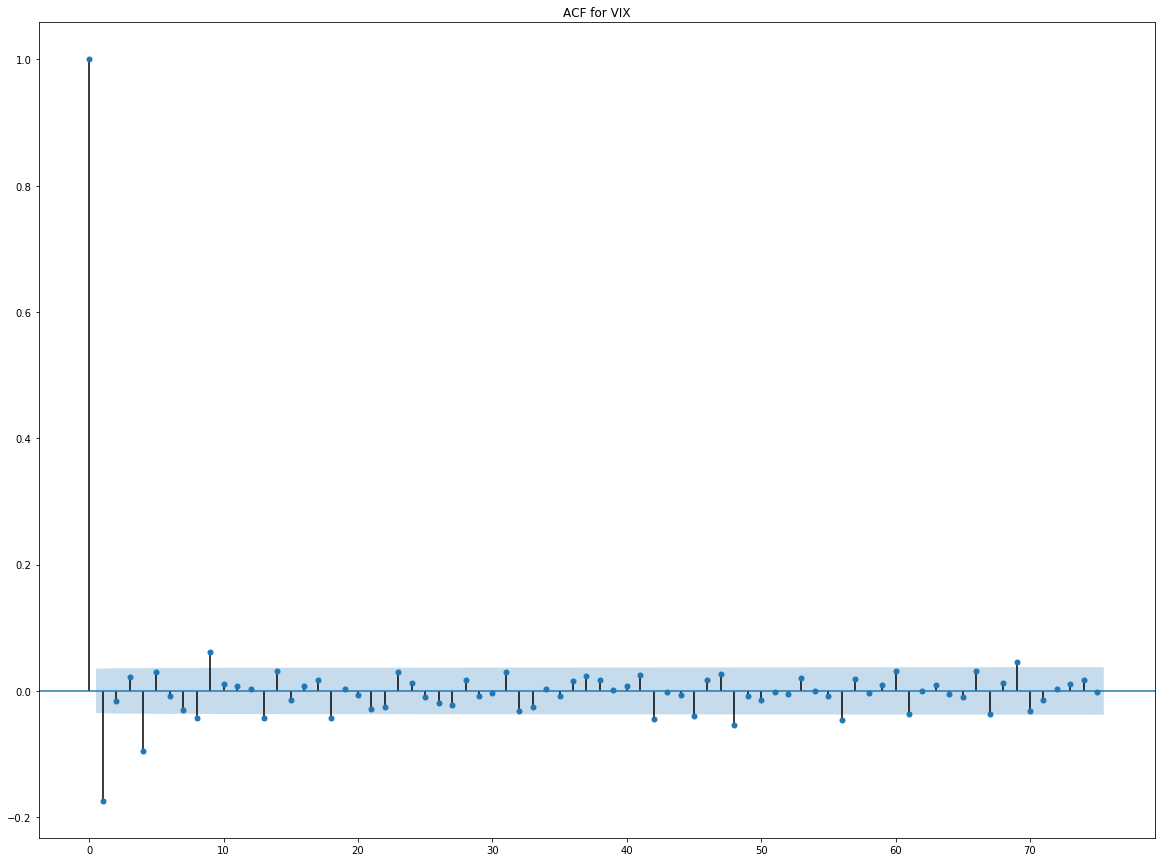

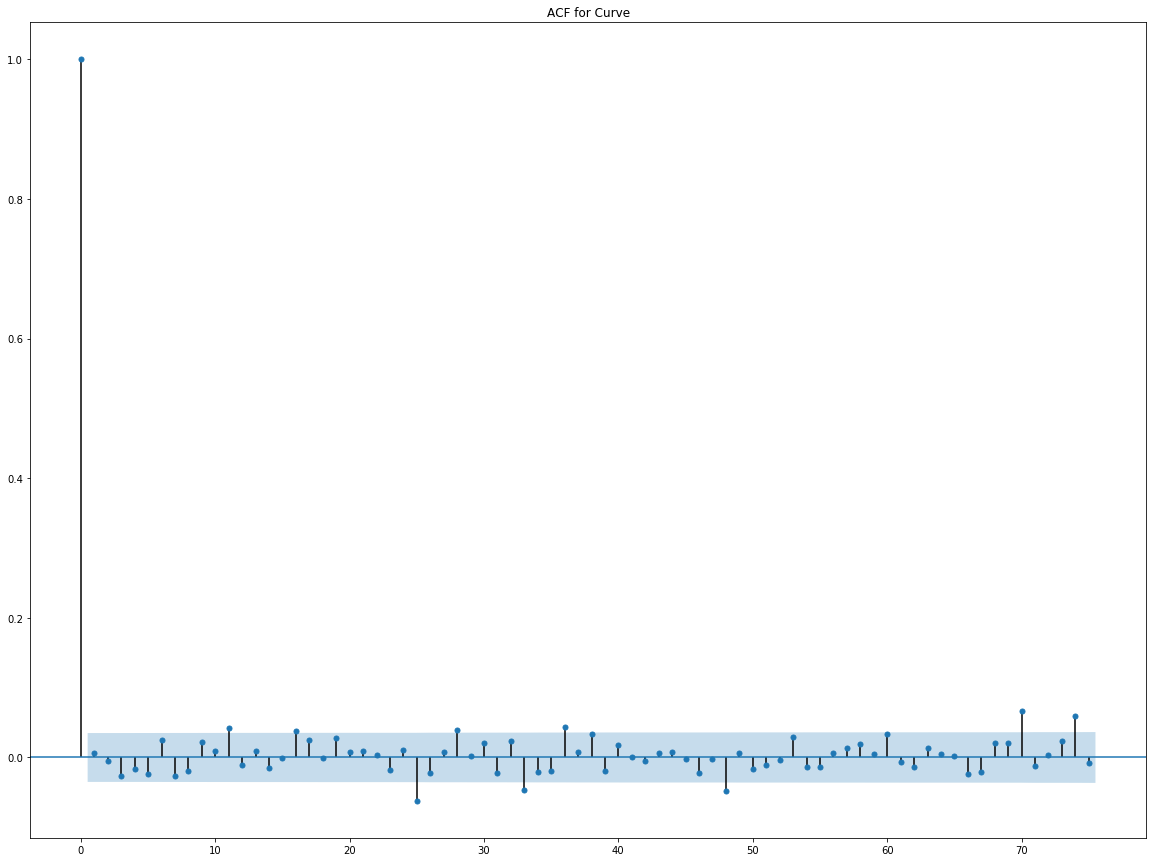

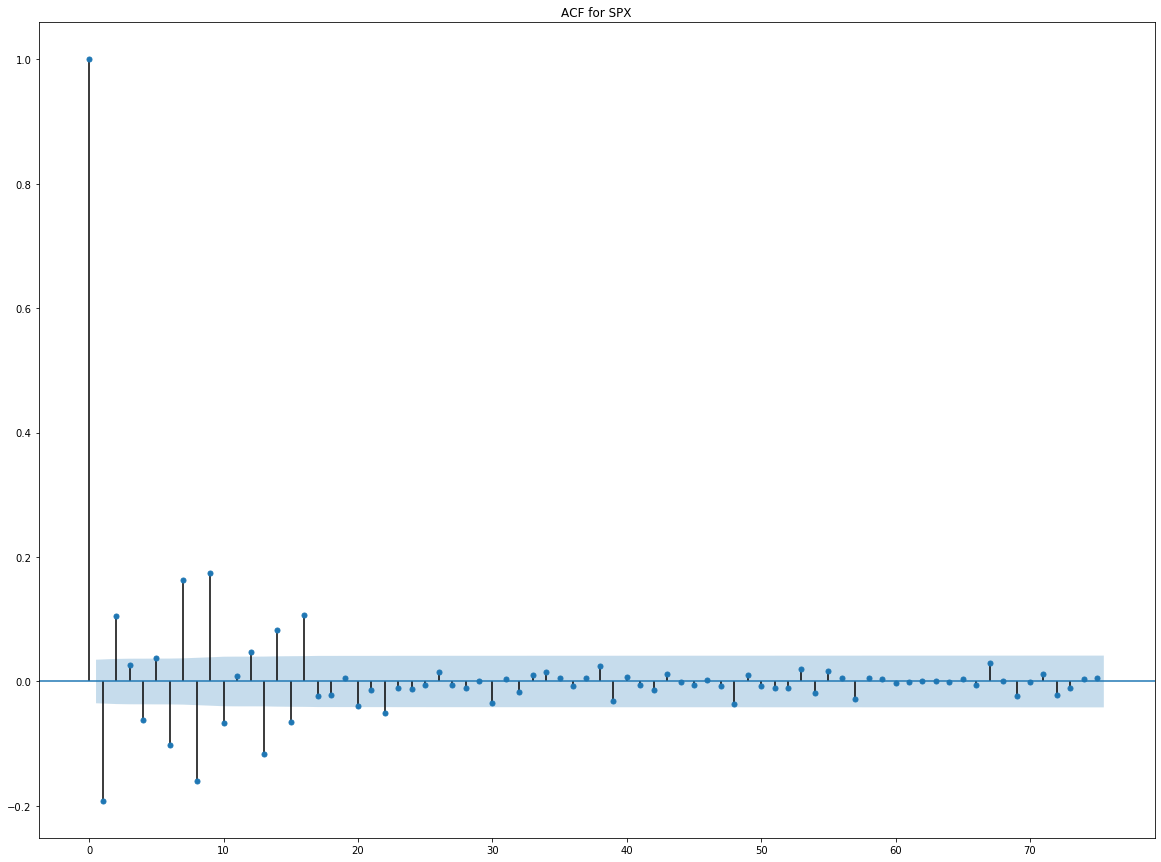

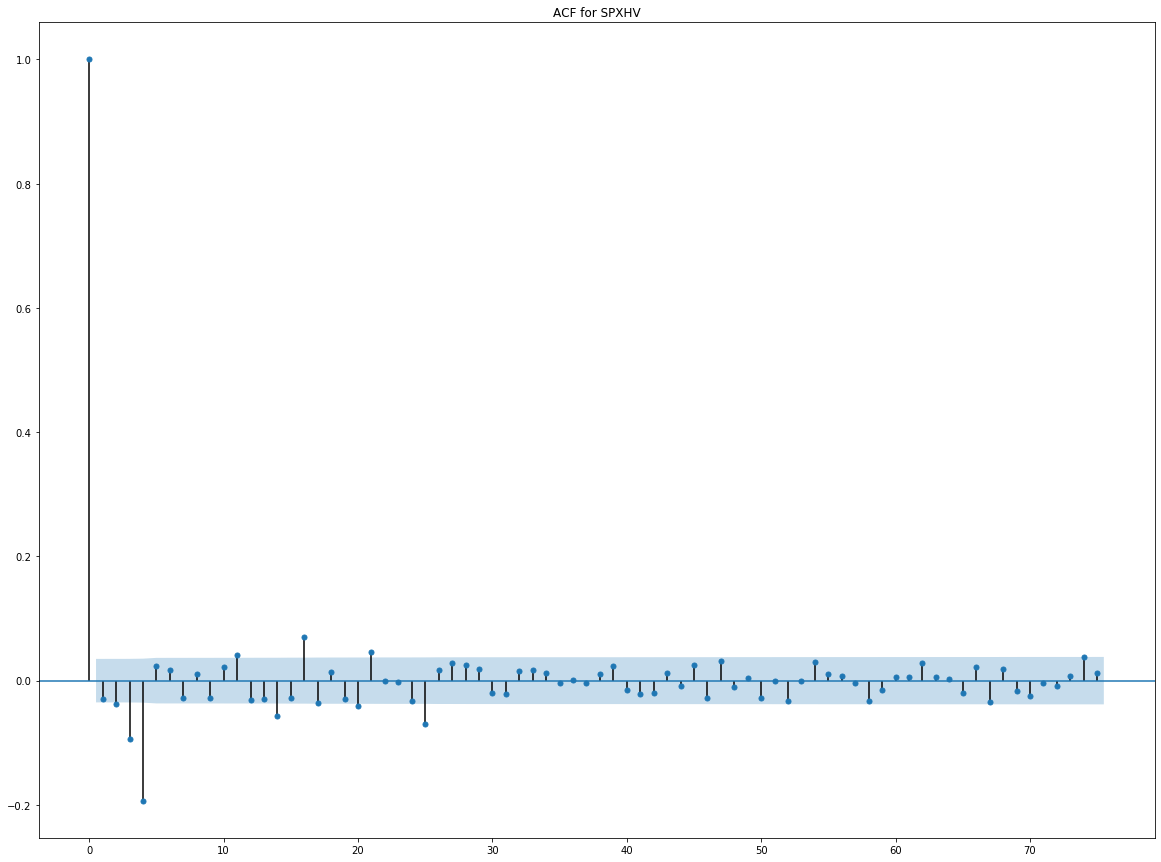

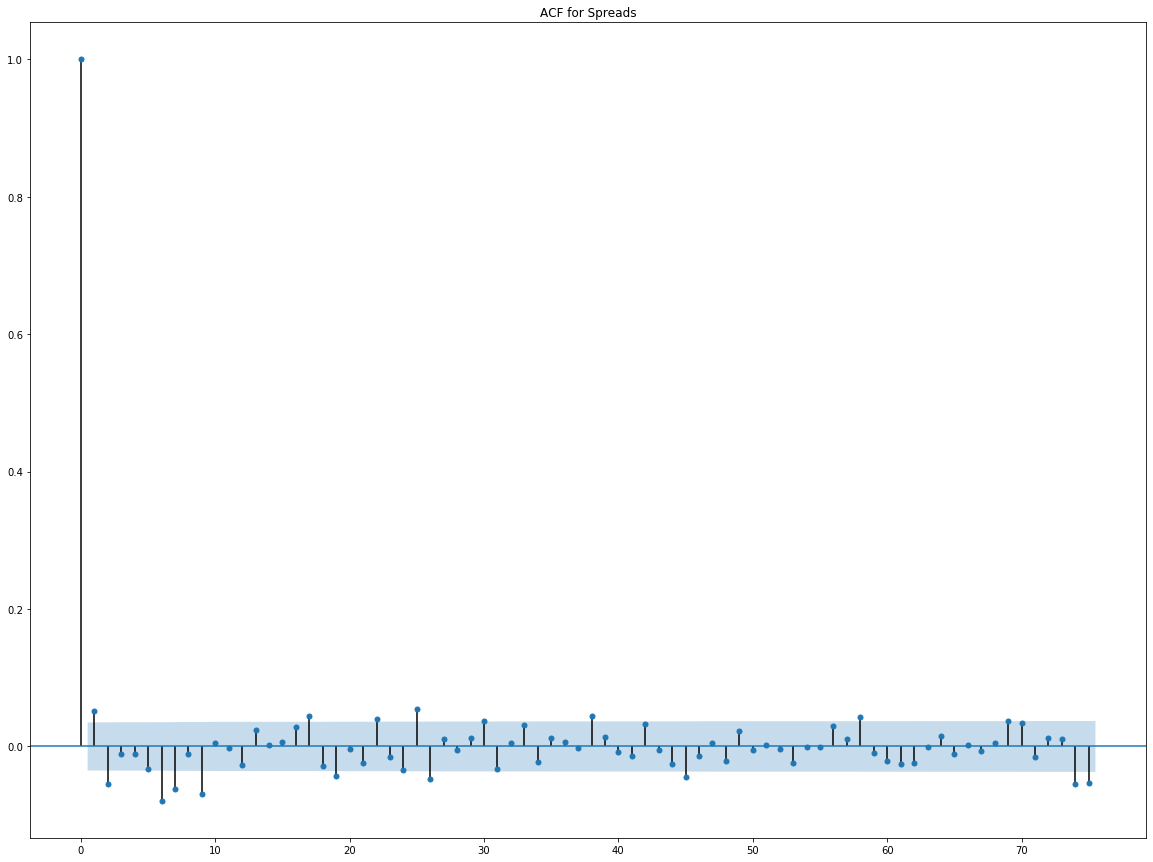

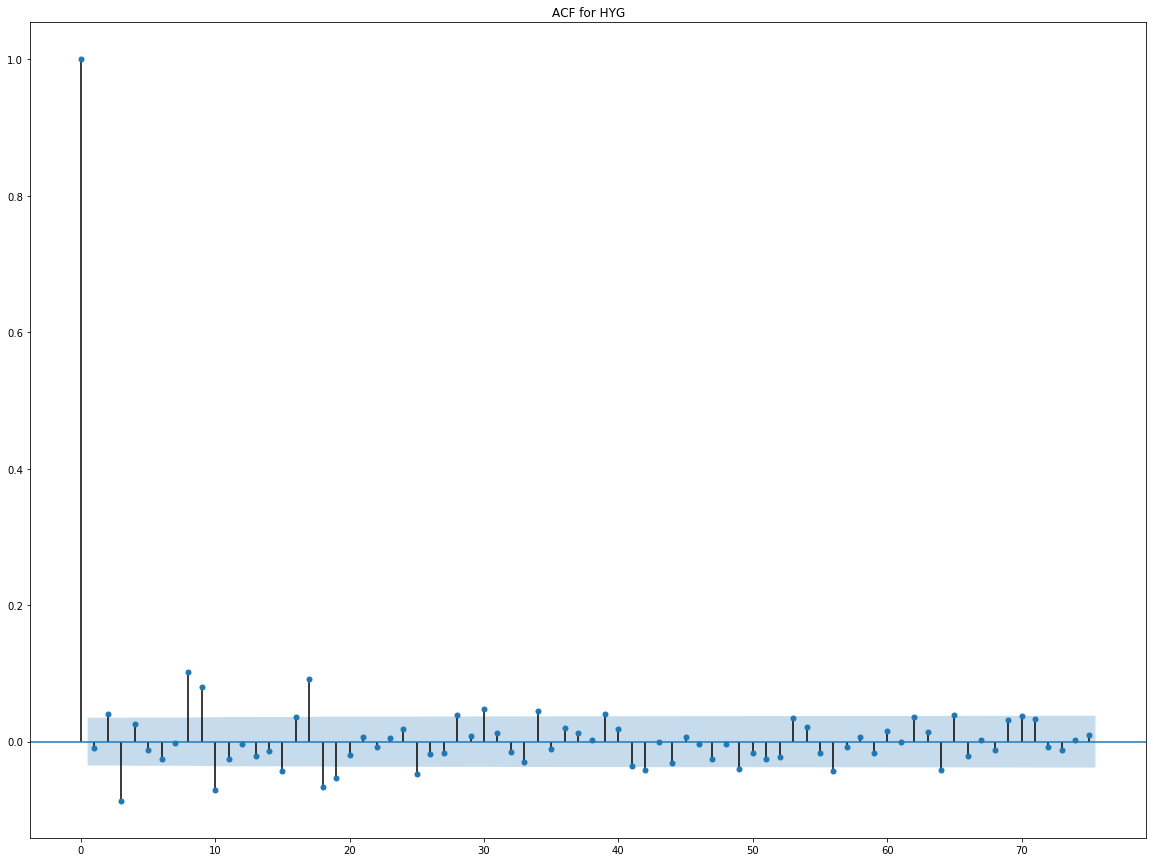

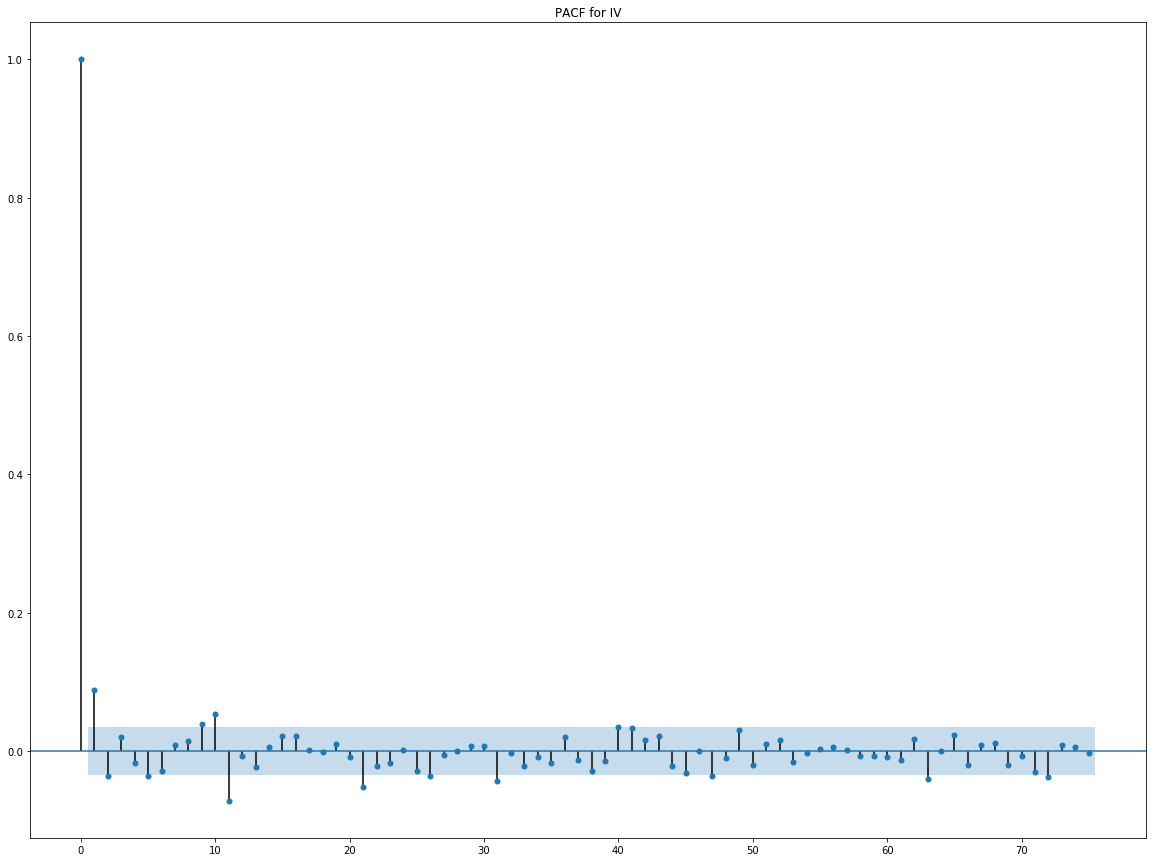

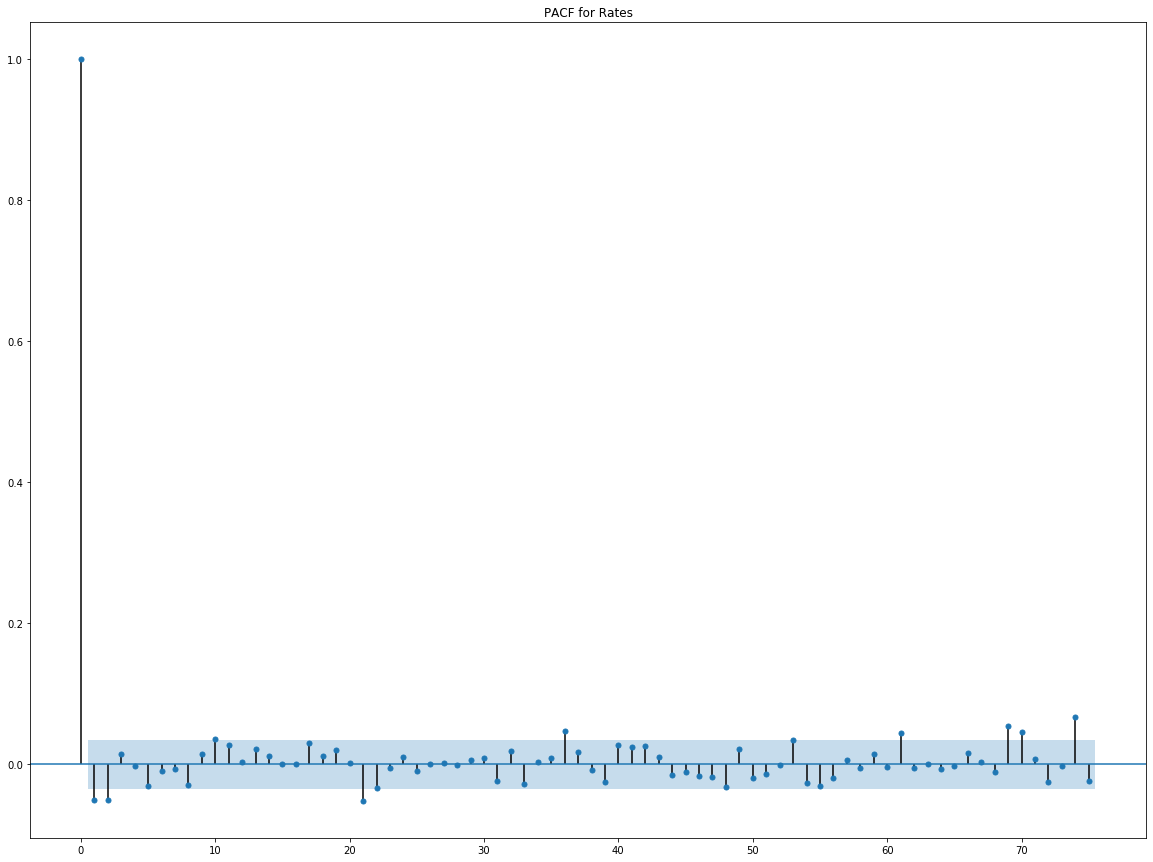

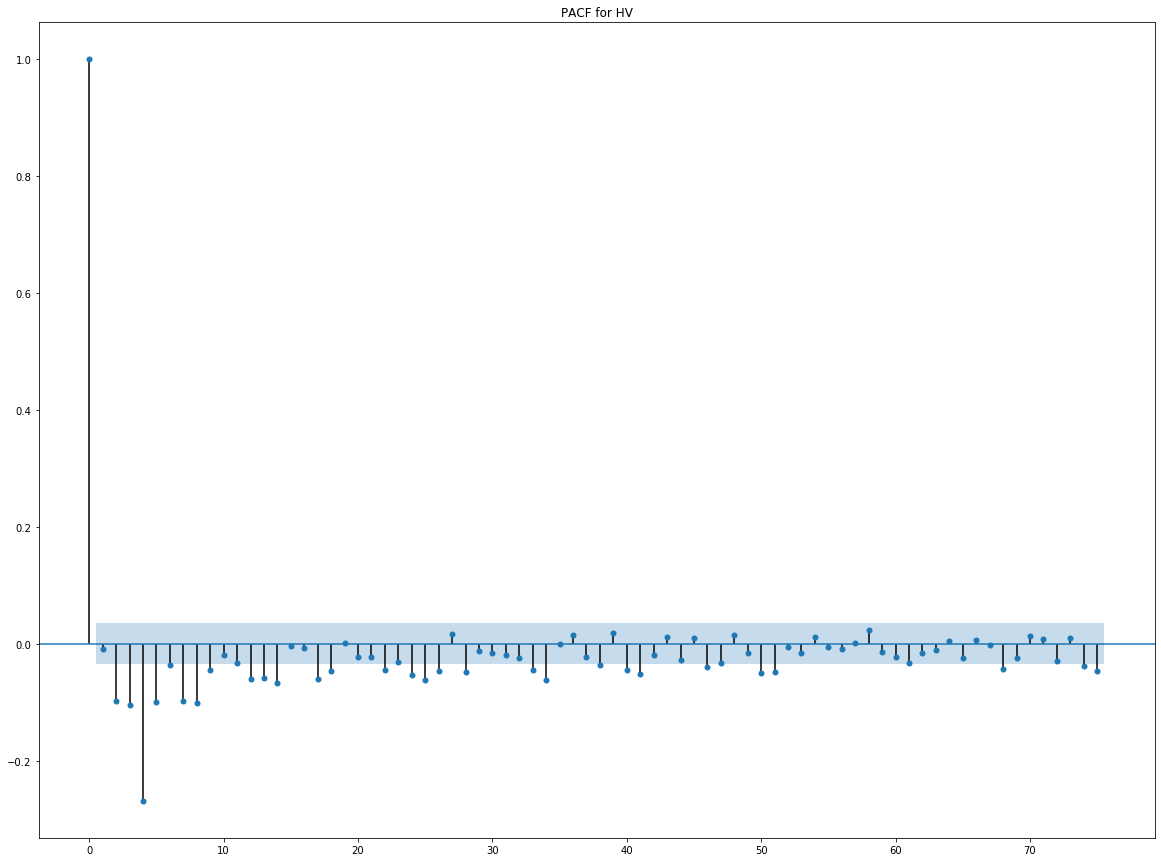

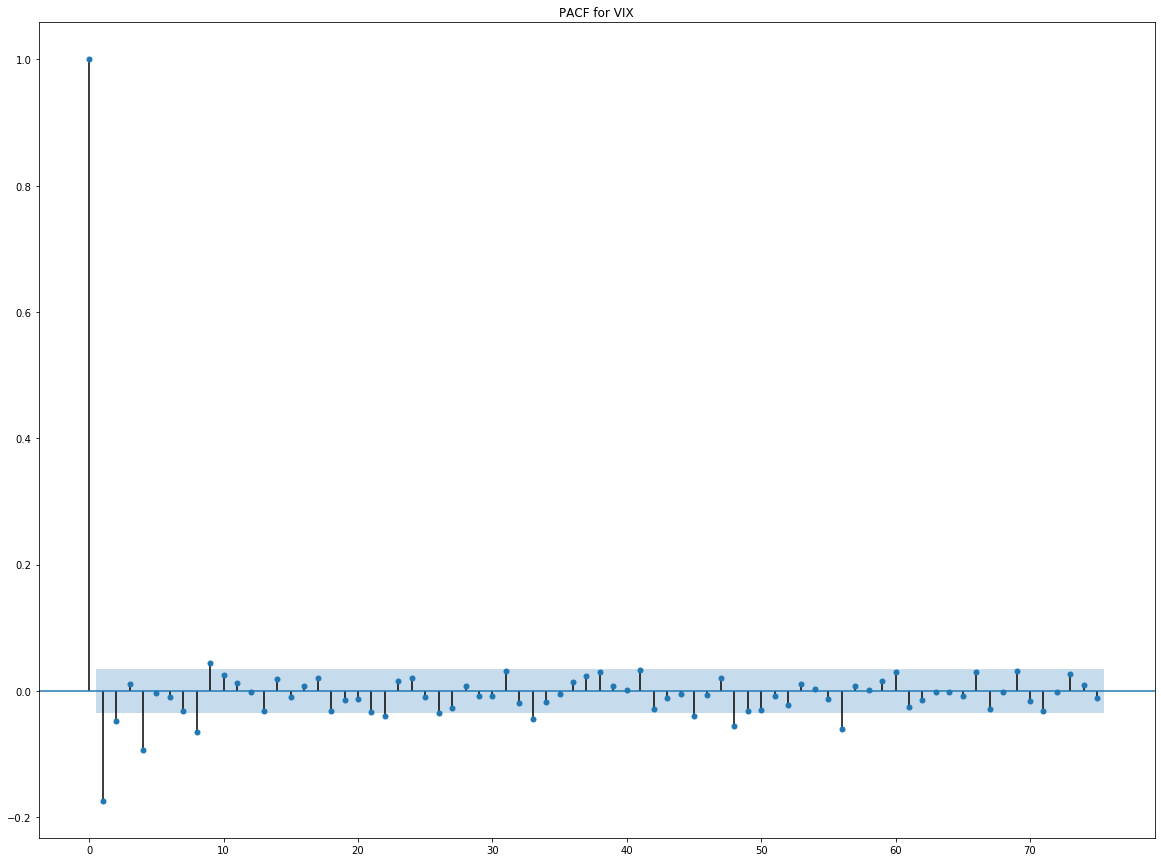

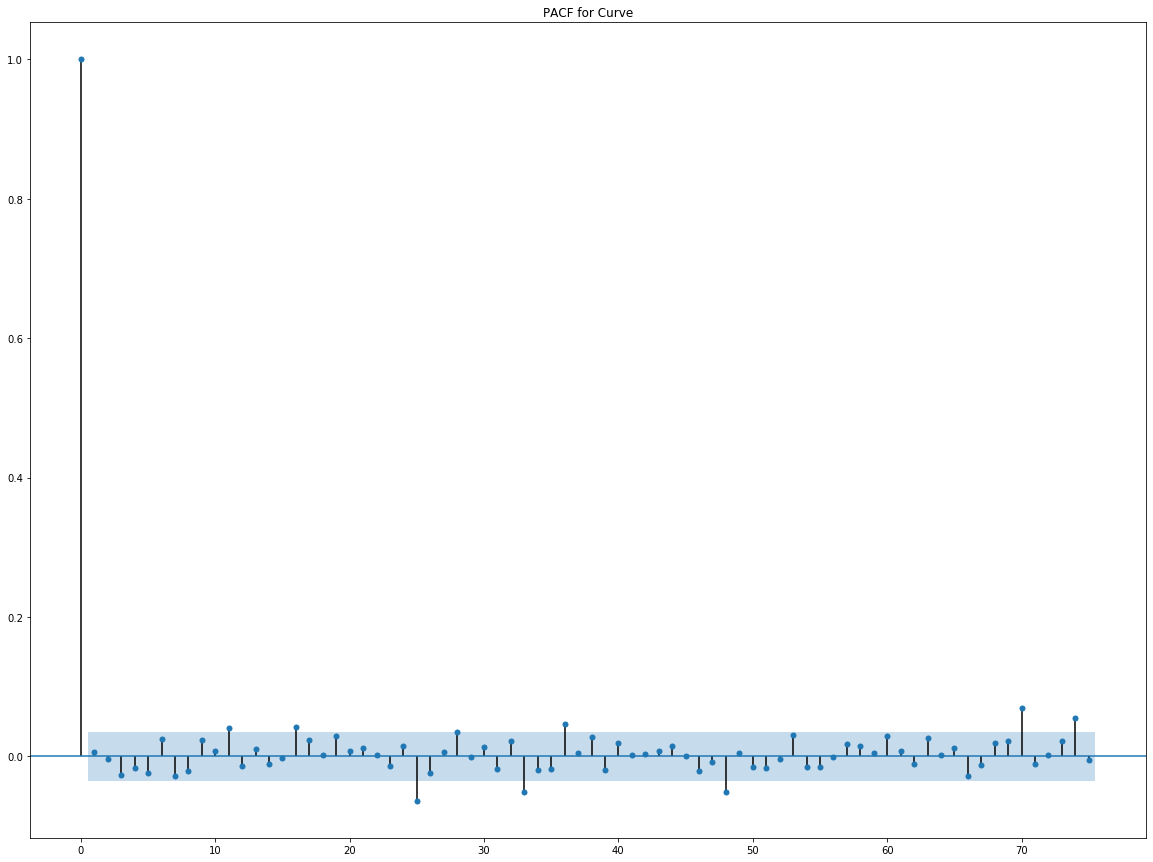

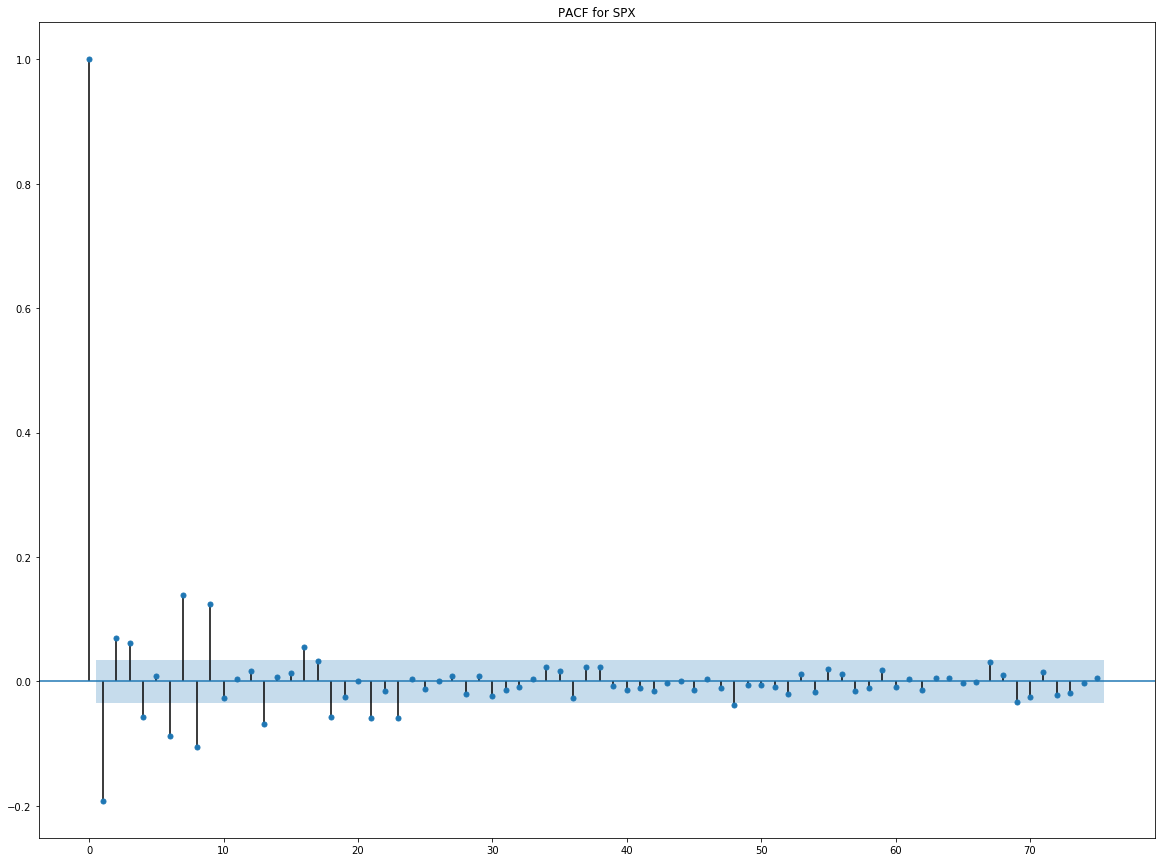

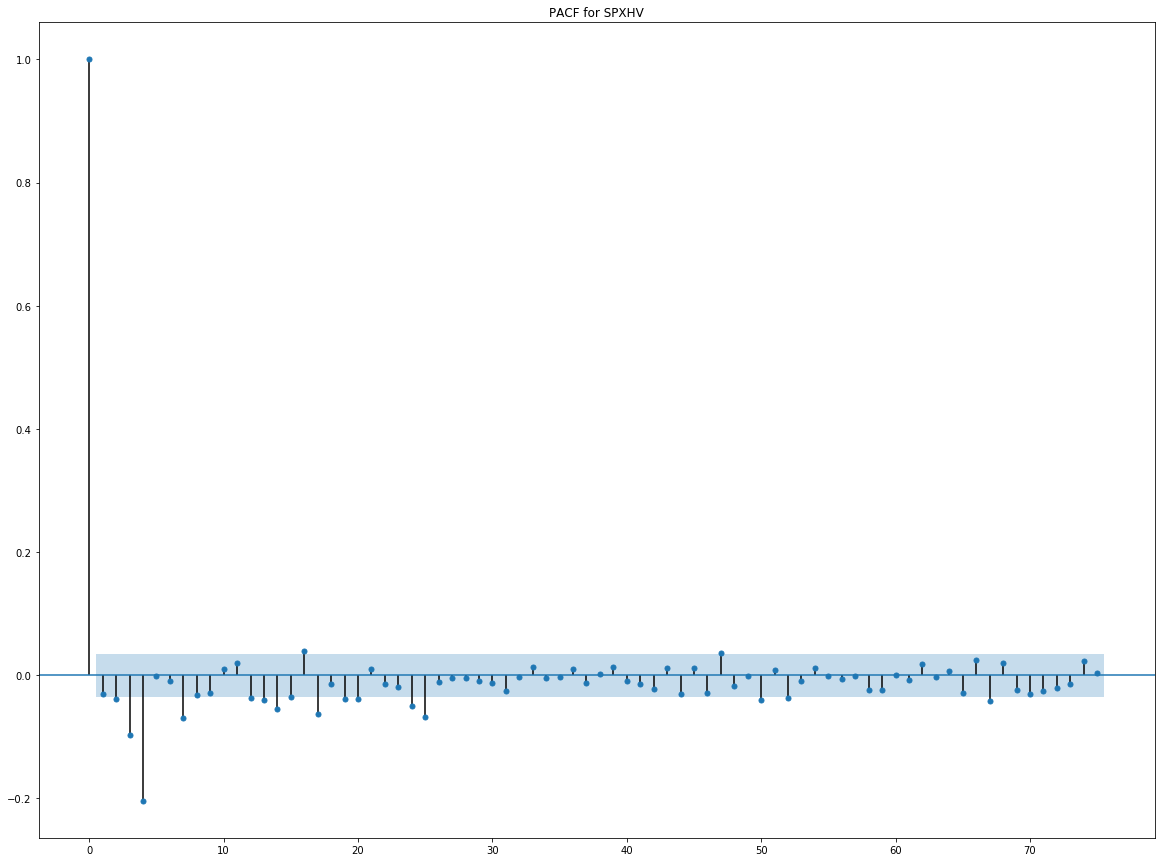

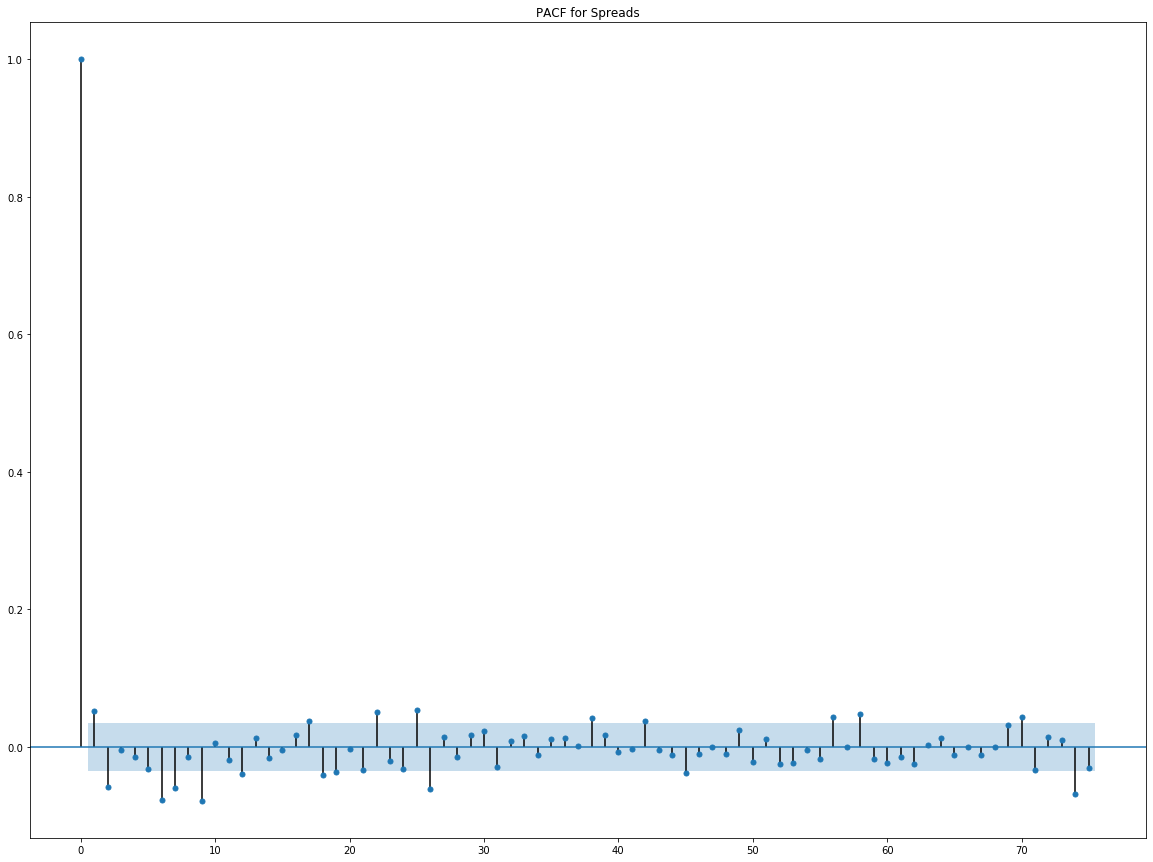

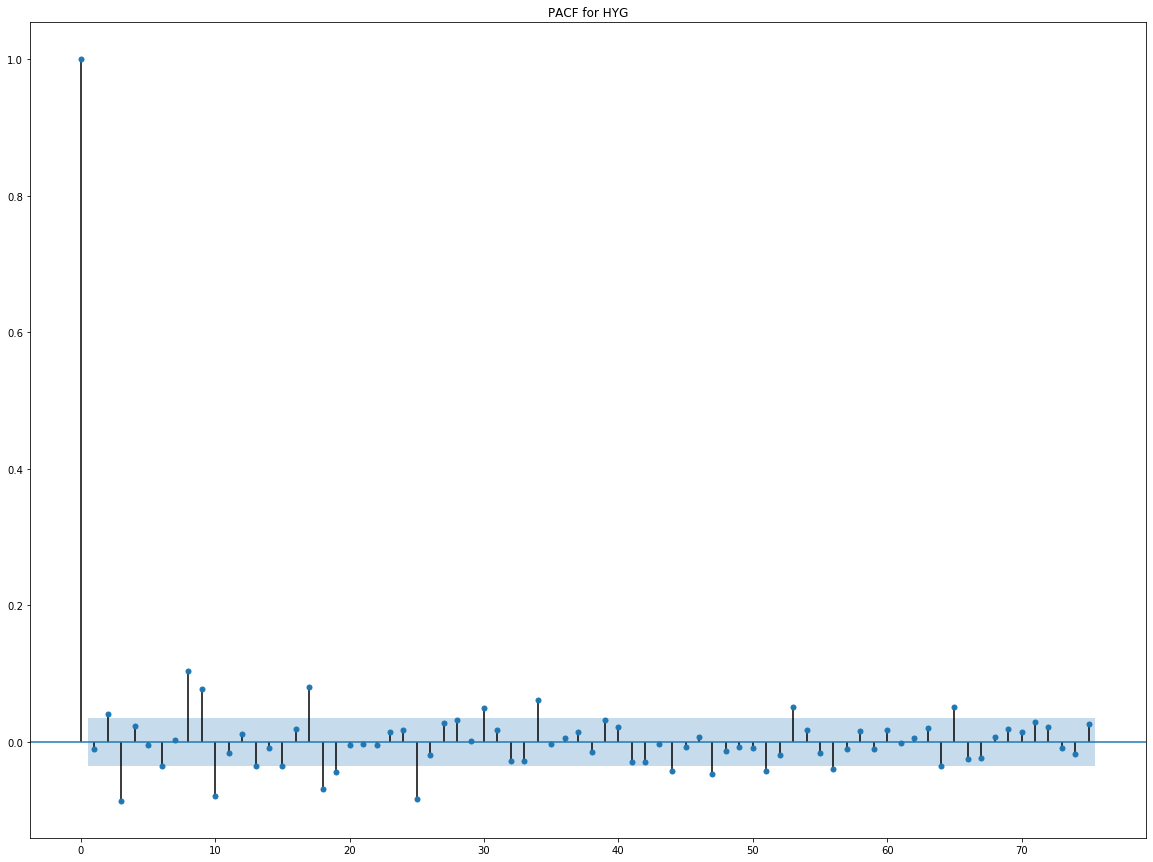

In [33]:
for i in t:
    plot_acf(t[i],lags=75)
    plt.title('ACF for %s'%i)
    
for j in t:
    plot_pacf(t[j], lags=75)
    plt.title('PACF for %s'%j)

# Run Granger Causality Tests on Every Differenced Variable

In [34]:
grangers_causation_matrix(t, variables = t.columns)

C:\Users\pjant\Miniconda3\envs\data601\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 8, but rank is 1
  'rank is %d' % (J, J_), ValueWarning)
C:\Users\pjant\Miniconda3\envs\data601\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 9, but rank is 1
  'rank is %d' % (J, J_), ValueWarning)


,IV_x,Rates_x,HV_x,VIX_x,Curve_x,SPX_x,SPXHV_x,Spreads_x,HYG_x
IV_y,1.0,0.0001,0.0001,0.0000,0.0136,0.1797,0.0000,0.0068,0.0000
Rates_y,0.0,1.0000,0.0002,0.0000,0.0009,0.0157,0.0982,0.0046,0.0105
HV_y,0.0,0.0005,1.0000,0.0000,0.0031,0.0182,0.0078,0.1245,0.0000
VIX_y,0.0,0.0085,0.0002,1.0000,0.0002,0.0000,0.0000,0.0000,0.0000
Curve_y,0.0,0.0066,0.0088,0.0019,1.0000,0.0188,0.0129,0.0006,0.0443
SPX_y,0.0,0.0798,0.0009,0.0000,0.0171,1.0000,0.0000,0.0041,0.0004
SPXHV_y,0.0,0.2278,0.0017,0.0002,0.3514,0.0000,1.0000,0.0090,0.0104
Spreads_y,0.0,0.0000,0.0005,0.0000,0.0001,0.0000,0.0006,1.0000,0.0000
HYG_y,0.0,0.1918,0.0002,0.0000,0.0013,0.0000,0.0002,0.0000,1.0000


In [35]:
from statsmodels.tsa.stattools import grangercausalitytests
print(grangercausalitytests(t[['IV','Rates']], maxlag=30, addconst=True, verbose=True))


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0079  , p=0.9291  , df_denom=3128, df_num=1
ssr based chi2 test:   chi2=0.0079  , p=0.9290  , df=1
likelihood ratio test: chi2=0.0079  , p=0.9290  , df=1
parameter F test:         F=0.0079  , p=0.9291  , df_denom=3128, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.7281  , p=0.1778  , df_denom=3125, df_num=2
ssr based chi2 test:   chi2=3.4618  , p=0.1771  , df=2
likelihood ratio test: chi2=3.4599  , p=0.1773  , df=2
parameter F test:         F=1.7281  , p=0.1778  , df_denom=3125, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.7347  , p=0.1577  , df_denom=3122, df_num=3
ssr based chi2 test:   chi2=5.2157  , p=0.1567  , df=3
likelihood ratio test: chi2=5.2113  , p=0.1570  , df=3
parameter F test:         F=1.7347  , p=0.1577  , df_denom=3122, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.8707  , p=0.

ssr based F test:         F=2.5962  , p=0.0000  , df_denom=3041, df_num=30
ssr based chi2 test:   chi2=79.4492 , p=0.0000  , df=30
likelihood ratio test: chi2=78.4488 , p=0.0000  , df=30
parameter F test:         F=2.5962  , p=0.0000  , df_denom=3041, df_num=30
{1: ({'ssr_ftest': (0.00792792555892015, 0.9290566959503538, 3128.0, 1), 'ssr_chi2test': (0.007935529068087912, 0.9290170709874197, 1), 'lrtest': (0.007935519011880388, 0.9290171158447383, 1), 'params_ftest': (0.007927925558613174, 0.9290566959503538, 3128.0, 1.0)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x0000019FA8A03C88>, <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x0000019FA8A03D30>, array([[0., 1., 0.]])]), 2: ({'ssr_ftest': (1.728121384392977, 0.17778746849106442, 3125.0, 2), 'ssr_chi2test': (3.461772757216011, 0.17712733848403395, 2), 'lrtest': (3.4598598112352192, 0.17729683704663116, 2), 'params_ftest': (1.7281213843937042, 0.1777874684910371, 3125.0, 2.0)},

# Run Cointegration Tests for Each of the Differenced Variables

In [36]:
cointegration_test(t)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
IV     ::  5834.83   > 179.5199  =>   True
Rates  ::  4831.26   > 143.6691  =>   True
HV     ::  3846.0    > 111.7797  =>   True
VIX    ::  3150.28   > 83.9383   =>   True
Curve  ::  2500.88   > 60.0627   =>   True
SPX    ::  1916.94   > 40.1749   =>   True
SPXHV  ::  1359.02   > 24.2761   =>   True
Spreads ::  878.55    > 12.3212   =>   True
HYG    ::  417.58    > 4.1296    =>   True


# Run Dickey-Fuller Tests on the Differenced Data to Check for Stationarity

In [37]:
# ADF Test on each column of 1st Differences Dataframe
for name, column in t.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "IV" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -16.8053
 No. Lags Chosen       = 10
 Critical value 1%     = -3.432
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Rates" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -42.5907
 No. Lags Chosen       = 1
 Critical value 1%     = -3.432
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "HV" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05


# Test for best Lags to Use

In [38]:
model = VAR(t)
for i in [1,2,3,4,5,6,7,8,9]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

C:\Users\pjant\Miniconda3\envs\data601\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Lag Order = 1
AIC :  -2.930671712169923
BIC :  -2.756791260263383
FPE :  0.05336119317954051
HQIC:  -2.8682632088869973 

Lag Order = 2
AIC :  -3.0169672436060475
BIC :  -2.6865062862628055
FPE :  0.048949510919067026
HQIC:  -2.898357540008574 

Lag Order = 3
AIC :  -3.0872853002648375
BIC :  -2.6001603007747263
FPE :  0.04562584253861029
HQIC:  -2.9124425853399107 

Lag Order = 4
AIC :  -3.269889024626245
BIC :  -2.626016374097309
FPE :  0.03801102257197024
HQIC:  -3.0387814590689364 

Lag Order = 5
AIC :  -3.299319170546147
BIC :  -2.4986151878190777
FPE :  0.03690899215722201
HQIC:  -3.0119148867253376 

Lag Order = 6
AIC :  -3.334528383832596
BIC :  -2.376909315395039
FPE :  0.035632551230572664
HQIC:  -2.990795485756754 

Lag Order = 7
AIC :  -3.394968256560187
BIC :  -2.2803502764609203
FPE :  0.033543348083233296
HQIC:  -2.994874819843094 

Lag Order = 8
AIC :  -3.4617959298537304
BIC :  -2.1900951396167136
FPE :  0.03137576976664415
HQIC:  -3.005310001680159 

Lag Order = 9
AIC

In [39]:
x = model.select_order(maxlags=20)
x.summary()

,AIC,BIC,FPE,HQIC
0,-2.735,-2.717,0.06492,-2.728
1,-2.918,-2.744*,0.05402,-2.856
2,-3.007,-2.675,0.04943,-2.888
3,-3.079,-2.589,0.04601,-2.903
4,-3.263,-2.616,0.03827,-3.031*
5,-3.290,-2.486,0.03724,-3.002
6,-3.325,-2.364,0.03597,-2.980
7,-3.388,-2.269,0.03378,-2.986
8,-3.457,-2.181,0.03152,-2.999
9,-3.507,-2.074,0.02999,-2.993


# Fit the Model

In [40]:
model_fitted = model.fit(20)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 07, May, 2020
Time:                     16:44:53
--------------------------------------------------------------------
No. of Equations:         9.00000    BIC:                  -0.468501
Nobs:                     3112.00    HQIC:                  -2.49607
Log likelihood:          -32461.6    FPE:                  0.0265007
AIC:                     -3.63177    Det(Omega_mle):       0.0159327
--------------------------------------------------------------------
Results for equation IV
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const              -0.031531         0.051368           -0.614           0.539
L1.IV               0.032792         0.020359            1.611           0.107
L1.Rates            3.410653         1.285731            2.653         

# Run Durbin Watson Stats on Fitted Model

In [41]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(t.columns, out):
    print((col), ':', round(val, 2))

IV : 2.01
Rates : 2.0
HV : 2.0
VIX : 2.0
Curve : 2.0
SPX : 2.0
SPXHV : 2.0
Spreads : 2.0
HYG : 2.0


# Run the Forecasts

In [42]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input = t.values[-lag_order:]
forecast_input

20


array([[ 1.67400000e+01, -1.00100000e-01,  4.99390786e-02,
         2.15700000e+01, -6.60000000e-02, -2.60740000e+02,
         1.75380832e+01, -4.00000000e+00, -3.23000000e+00],
       [-7.96750000e+00,  1.91300000e-01, -6.32424837e-01,
        -1.76400000e+01,  1.29400000e-01,  2.30380000e+02,
         3.44674744e+01,  4.00000000e+00,  2.44000000e+00],
       [-1.11525000e+01, -2.11500000e-01,  4.65440860e-01,
         2.48600000e+01, -1.24000000e-01, -3.24890000e+02,
         1.49478973e+01,  3.25000000e+00, -4.40000000e+00],
       [-5.28000000e+00,  2.42200000e-01,  7.49435978e-01,
        -6.78000000e+00,  1.21400000e-01,  1.43060000e+02,
         2.13726435e+01, -1.21200000e+01,  7.10000000e-01],
       [ 1.46400000e+01,  7.80000000e-02, -2.88171991e-01,
         5.40000000e-01,  5.68000000e-02, -1.31090000e+02,
        -1.49211115e+01, -3.51000000e+00, -3.37000000e+00],
       [ 1.35100000e+01, -6.24000000e-02, -1.45415182e-01,
        -4.45000000e+00, -9.34000000e-02,  1.129000

# Test the Model

In [43]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input = t.values[-lag_order:]
forecast_input

20


array([[ 1.67400000e+01, -1.00100000e-01,  4.99390786e-02,
         2.15700000e+01, -6.60000000e-02, -2.60740000e+02,
         1.75380832e+01, -4.00000000e+00, -3.23000000e+00],
       [-7.96750000e+00,  1.91300000e-01, -6.32424837e-01,
        -1.76400000e+01,  1.29400000e-01,  2.30380000e+02,
         3.44674744e+01,  4.00000000e+00,  2.44000000e+00],
       [-1.11525000e+01, -2.11500000e-01,  4.65440860e-01,
         2.48600000e+01, -1.24000000e-01, -3.24890000e+02,
         1.49478973e+01,  3.25000000e+00, -4.40000000e+00],
       [-5.28000000e+00,  2.42200000e-01,  7.49435978e-01,
        -6.78000000e+00,  1.21400000e-01,  1.43060000e+02,
         2.13726435e+01, -1.21200000e+01,  7.10000000e-01],
       [ 1.46400000e+01,  7.80000000e-02, -2.88171991e-01,
         5.40000000e-01,  5.68000000e-02, -1.31090000e+02,
        -1.49211115e+01, -3.51000000e+00, -3.37000000e+00],
       [ 1.35100000e+01, -6.24000000e-02, -1.45415182e-01,
        -4.45000000e+00, -9.34000000e-02,  1.129000

In [44]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df_test.index[-nobs:], columns=t.columns + '_1d')
df_forecast

,IV_1d,Rates_1d,HV_1d,VIX_1d,Curve_1d,SPX_1d,SPXHV_1d,Spreads_1d,HYG_1d
Date,,,,,,,,,
2020-04-09,-3.044554,-0.115027,0.492907,1.876243,-0.033476,-4.123314,-4.261522,-3.740100,0.206853
2020-04-10,1.113656,0.056604,-0.031446,-1.240792,0.073184,10.955960,-21.342014,0.766518,0.747001
2020-04-13,-2.241226,-0.004579,0.384148,-1.691857,-0.021665,23.051226,3.827197,-0.249070,-0.529546
2020-04-14,1.989863,-0.038947,-0.213143,-0.881030,-0.017476,-35.910711,-6.175919,0.862897,0.699770
2020-04-15,2.226151,0.011203,0.139442,-3.896684,-0.032960,33.131874,12.043417,0.269263,1.659132
2020-04-16,-2.355003,0.016992,0.149253,1.295388,-0.017325,-32.323983,8.792384,2.296196,1.482234
2020-04-17,2.008654,0.067854,0.107000,-0.342076,0.026250,36.099090,10.345084,0.158765,1.937728
2020-04-20,2.244994,-0.006966,0.394469,4.542968,0.002012,-21.666031,7.950152,1.391070,-0.403815
2020-04-21,3.954961,0.032543,-0.008803,1.374225,0.023857,24.778626,-9.386251,-1.107111,-0.347778


In [45]:
forecast_input.shape, nobs, fc.shape

((20, 9), 10, (10, 9))

In [46]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
#        if second_diff:
#            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [47]:
df_results = invert_transformation(df_train, df_forecast, second_diff=False)       
df_results.loc[:, ['IV_forecast', 'Rates_forecast', 'HV_forecast', 'VIX_forecast', 'Curve_forecast',
                   'SPX_forecast', 'SPXHV_forecast', 'CDXHY_forecast','Spreads_forecast','HYG_forecast']]

C:\Users\pjant\Miniconda3\envs\data601\lib\site-packages\pandas\core\indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


,IV_forecast,Rates_forecast,HV_forecast,VIX_forecast,Curve_forecast,SPX_forecast,SPXHV_forecast,CDXHY_forecast,Spreads_forecast,HYG_forecast
Date,,,,,,,,,,
2020-04-09,78.105446,0.710273,1.003907,45.226243,0.280924,2745.856686,55.978425,NaN,1.579900,77.506853
2020-04-10,79.219102,0.766877,0.972461,43.985451,0.354108,2756.812647,34.636411,NaN,2.346418,78.253854
2020-04-13,76.977876,0.762298,1.356609,42.293594,0.332443,2779.863873,38.463608,NaN,2.097348,77.724307
2020-04-14,78.967739,0.723351,1.143466,41.412564,0.314967,2743.953162,32.287688,NaN,2.960245,78.424077
2020-04-15,81.193890,0.734554,1.282908,37.515880,0.282007,2777.085035,44.331105,NaN,3.229508,80.083210
2020-04-16,78.838886,0.751547,1.432161,38.811268,0.264682,2744.761052,53.123490,NaN,5.525704,81.565444
2020-04-17,80.847540,0.819400,1.539161,38.469192,0.290932,2780.860142,63.468574,NaN,5.684469,83.503172
2020-04-20,83.092534,0.812435,1.933630,43.012160,0.292944,2759.194112,71.418726,NaN,7.075539,83.099357
2020-04-21,87.047495,0.844978,1.924827,44.386386,0.316801,2783.972737,62.032475,NaN,5.968428,82.751578


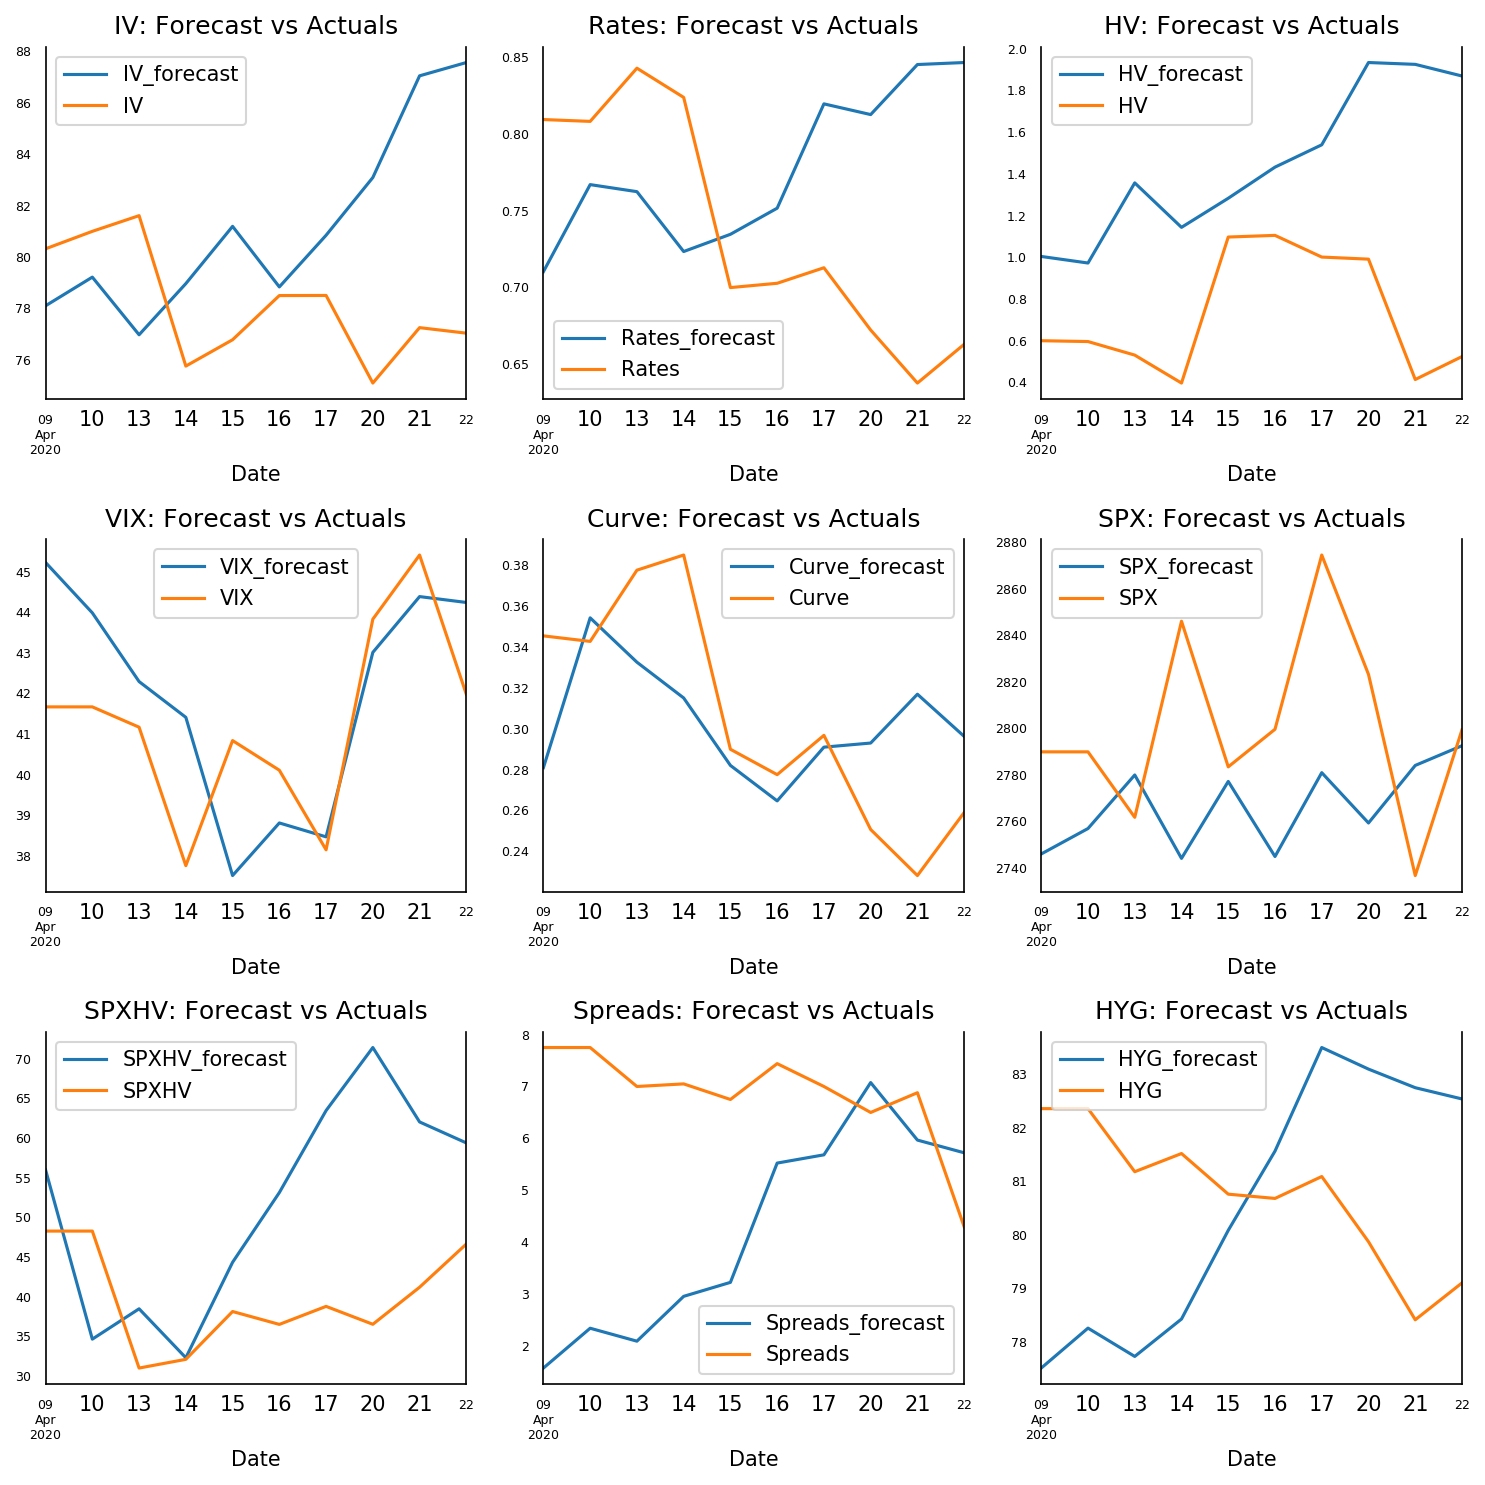

In [48]:
fig, axes = plt.subplots(nrows=int(len(df.columns)/3), ncols=3, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

# Run the Model Accuracy Statistics

In [49]:
# mape is mean absolute percentage error (errors / values)
# me is margin of error (a statistic expressing the amount of random sampling error in the results of a survey)
# mae is mean absolute error
# mpe is mean percentage error
# rmse is root mean squared error
# corr is correlation between the forecast and the actual values

from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})

print('Forecast Accuracy of: IV')
accuracy_prod = forecast_accuracy(df_results['IV_forecast'].values, df_test['IV'])
for k, v in accuracy_prod.items():
    print((k), ': ', round(v,4))

print('\nForecast Accuracy of: Rates')
accuracy_prod = forecast_accuracy(df_results['Rates_forecast'].values, df_test['Rates'])
for k, v in accuracy_prod.items():
    print((k), ': ', round(v,4))

print('\nForecast Accuracy of: HV')
accuracy_prod = forecast_accuracy(df_results['HV_forecast'].values, df_test['HV'])
for k, v in accuracy_prod.items():
    print((k), ': ', round(v,4))

print('\nForecast Accuracy of: VIX')
accuracy_prod = forecast_accuracy(df_results['VIX_forecast'].values, df_test['VIX'])
for k, v in accuracy_prod.items():
    print((k), ': ', round(v,4))

print('\nForecast Accuracy of: Curve')
accuracy_prod = forecast_accuracy(df_results['Curve_forecast'].values, df_test['Curve'])
for k, v in accuracy_prod.items():
    print((k), ': ', round(v,4))

print('\nForecast Accuracy of: SPX')
accuracy_prod = forecast_accuracy(df_results['SPX_forecast'].values, df_test['SPX'])
for k, v in accuracy_prod.items():
    print((k), ': ', round(v,4))

print('\nForecast Accuracy of: SPXHV')
accuracy_prod = forecast_accuracy(df_results['SPXHV_forecast'].values, df_test['SPXHV'])
for k, v in accuracy_prod.items():
    print((k), ': ', round(v,4))

print('\nForecast Accuracy of: Spreads')
accuracy_prod = forecast_accuracy(df_results['Spreads_forecast'].values, df_test['Spreads'])
for k, v in accuracy_prod.items():
    print((k), ': ', round(v,4))
    
print('\nForecast Accuracy of: HYG')
accuracy_prod = forecast_accuracy(df_results['HYG_forecast'].values, df_test['HYG'])
for k, v in accuracy_prod.items():
    print((k), ': ', round(v,4))

Forecast Accuracy of: IV
mape :  0.061
me :  2.9976
mae :  4.7234
mpe :  0.0397
rmse :  5.7915
corr :  -0.5591
minmax :  0.0563

Forecast Accuracy of: Rates
mape :  0.1468
me :  0.04
mae :  0.1041
mpe :  0.0688
rmse :  0.1179
corr :  -0.7176
minmax :  0.1267

Forecast Accuracy of: HV
mape :  1.291
me :  0.7202
mae :  0.7202
mpe :  1.291
rmse :  0.834
corr :  0.0936
minmax :  0.4766

Forecast Accuracy of: VIX
mape :  0.0482
me :  0.6764
mae :  1.9693
mpe :  0.0172
rmse :  2.2865
corr :  0.6033
minmax :  0.046

Forecast Accuracy of: Curve
mape :  0.1314
me :  -0.0026
mae :  0.0385
mpe :  0.0154
rmse :  0.0474
corr :  0.4094
minmax :  0.1162

Forecast Accuracy of: SPX
mape :  0.0167
me :  -33.9006
mae :  47.0299
mpe :  -0.0119
rmse :  56.5578
corr :  -0.2491
minmax :  0.0167

Forecast Accuracy of: SPXHV
mape :  0.3681
me :  11.7795
mae :  14.5057
mpe :  0.3116
rmse :  17.4412
corr :  0.2057
minmax :  0.2502

Forecast Accuracy of: Spreads
mape :  0.4293
me :  -2.6229
mae :  3.0227
mpe :  -

# Next 10 Days Predictions

In [50]:
bd = pd.tseries.offsets.BusinessDay(n = nobs)
bd

<10 * BusinessDays>

In [51]:
ed = bd + df.index[-1]
fc_dates = pd.bdate_range(df.index[-1],ed)
fc_dates = fc_dates[1:nobs+1]
fc_dates

DatetimeIndex(['2020-04-23', '2020-04-24', '2020-04-27', '2020-04-28',
               '2020-04-29', '2020-04-30', '2020-05-01', '2020-05-04',
               '2020-05-05', '2020-05-06'],
              dtype='datetime64[ns]', freq='B')

In [52]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=fc_dates, columns=df.columns + '_1d')
df_forecast

,IV_1d,Rates_1d,HV_1d,VIX_1d,Curve_1d,SPX_1d,SPXHV_1d,Spreads_1d,HYG_1d
2020-04-23,-3.044554,-0.115027,0.492907,1.876243,-0.033476,-4.123314,-4.261522,-3.740100,0.206853
2020-04-24,1.113656,0.056604,-0.031446,-1.240792,0.073184,10.955960,-21.342014,0.766518,0.747001
2020-04-27,-2.241226,-0.004579,0.384148,-1.691857,-0.021665,23.051226,3.827197,-0.249070,-0.529546
2020-04-28,1.989863,-0.038947,-0.213143,-0.881030,-0.017476,-35.910711,-6.175919,0.862897,0.699770
2020-04-29,2.226151,0.011203,0.139442,-3.896684,-0.032960,33.131874,12.043417,0.269263,1.659132
2020-04-30,-2.355003,0.016992,0.149253,1.295388,-0.017325,-32.323983,8.792384,2.296196,1.482234
2020-05-01,2.008654,0.067854,0.107000,-0.342076,0.026250,36.099090,10.345084,0.158765,1.937728
2020-05-04,2.244994,-0.006966,0.394469,4.542968,0.002012,-21.666031,7.950152,1.391070,-0.403815
2020-05-05,3.954961,0.032543,-0.008803,1.374225,0.023857,24.778626,-9.386251,-1.107111,-0.347778
2020-05-06,0.517171,0.001309,-0.055815,-0.144769,-0.020610,8.492189,-2.646761,-0.244612,-0.210481


In [53]:
df_results = invert_transformation(df, df_forecast, second_diff=False)       
df_results = df_results.loc[:, ['IV_forecast', 'Rates_forecast', 'HV_forecast', 'VIX_forecast', 'Curve_forecast',
                   'SPX_forecast', 'SPXHV_forecast','Spreads_forecast','HYG_forecast']]
df_results

,IV_forecast,Rates_forecast,HV_forecast,VIX_forecast,Curve_forecast,SPX_forecast,SPXHV_forecast,Spreads_forecast,HYG_forecast
2020-04-23,73.995446,0.547973,1.016907,43.856243,0.225524,2795.186686,42.372391,0.559900,79.306853
2020-04-24,75.109102,0.604577,0.985461,42.615451,0.298708,2806.142647,21.030377,1.326418,80.053854
2020-04-27,72.867876,0.599998,1.369609,40.923594,0.277043,2829.193873,24.857574,1.077348,79.524307
2020-04-28,74.857739,0.561051,1.156466,40.042564,0.259567,2793.283162,18.681654,1.940245,80.224077
2020-04-29,77.083890,0.572254,1.295908,36.145880,0.226607,2826.415035,30.725071,2.209508,81.883210
2020-04-30,74.728886,0.589247,1.445161,37.441268,0.209282,2794.091052,39.517455,4.505704,83.365444
2020-05-01,76.737540,0.657100,1.552161,37.099192,0.235532,2830.190142,49.862540,4.664469,85.303172
2020-05-04,78.982534,0.650135,1.946630,41.642160,0.237544,2808.524112,57.812692,6.055539,84.899357
2020-05-05,82.937495,0.682678,1.937827,43.016386,0.261401,2833.302737,48.426441,4.948428,84.551578
2020-05-06,83.454666,0.683986,1.882012,42.871617,0.240791,2841.794926,45.779681,4.703816,84.341098


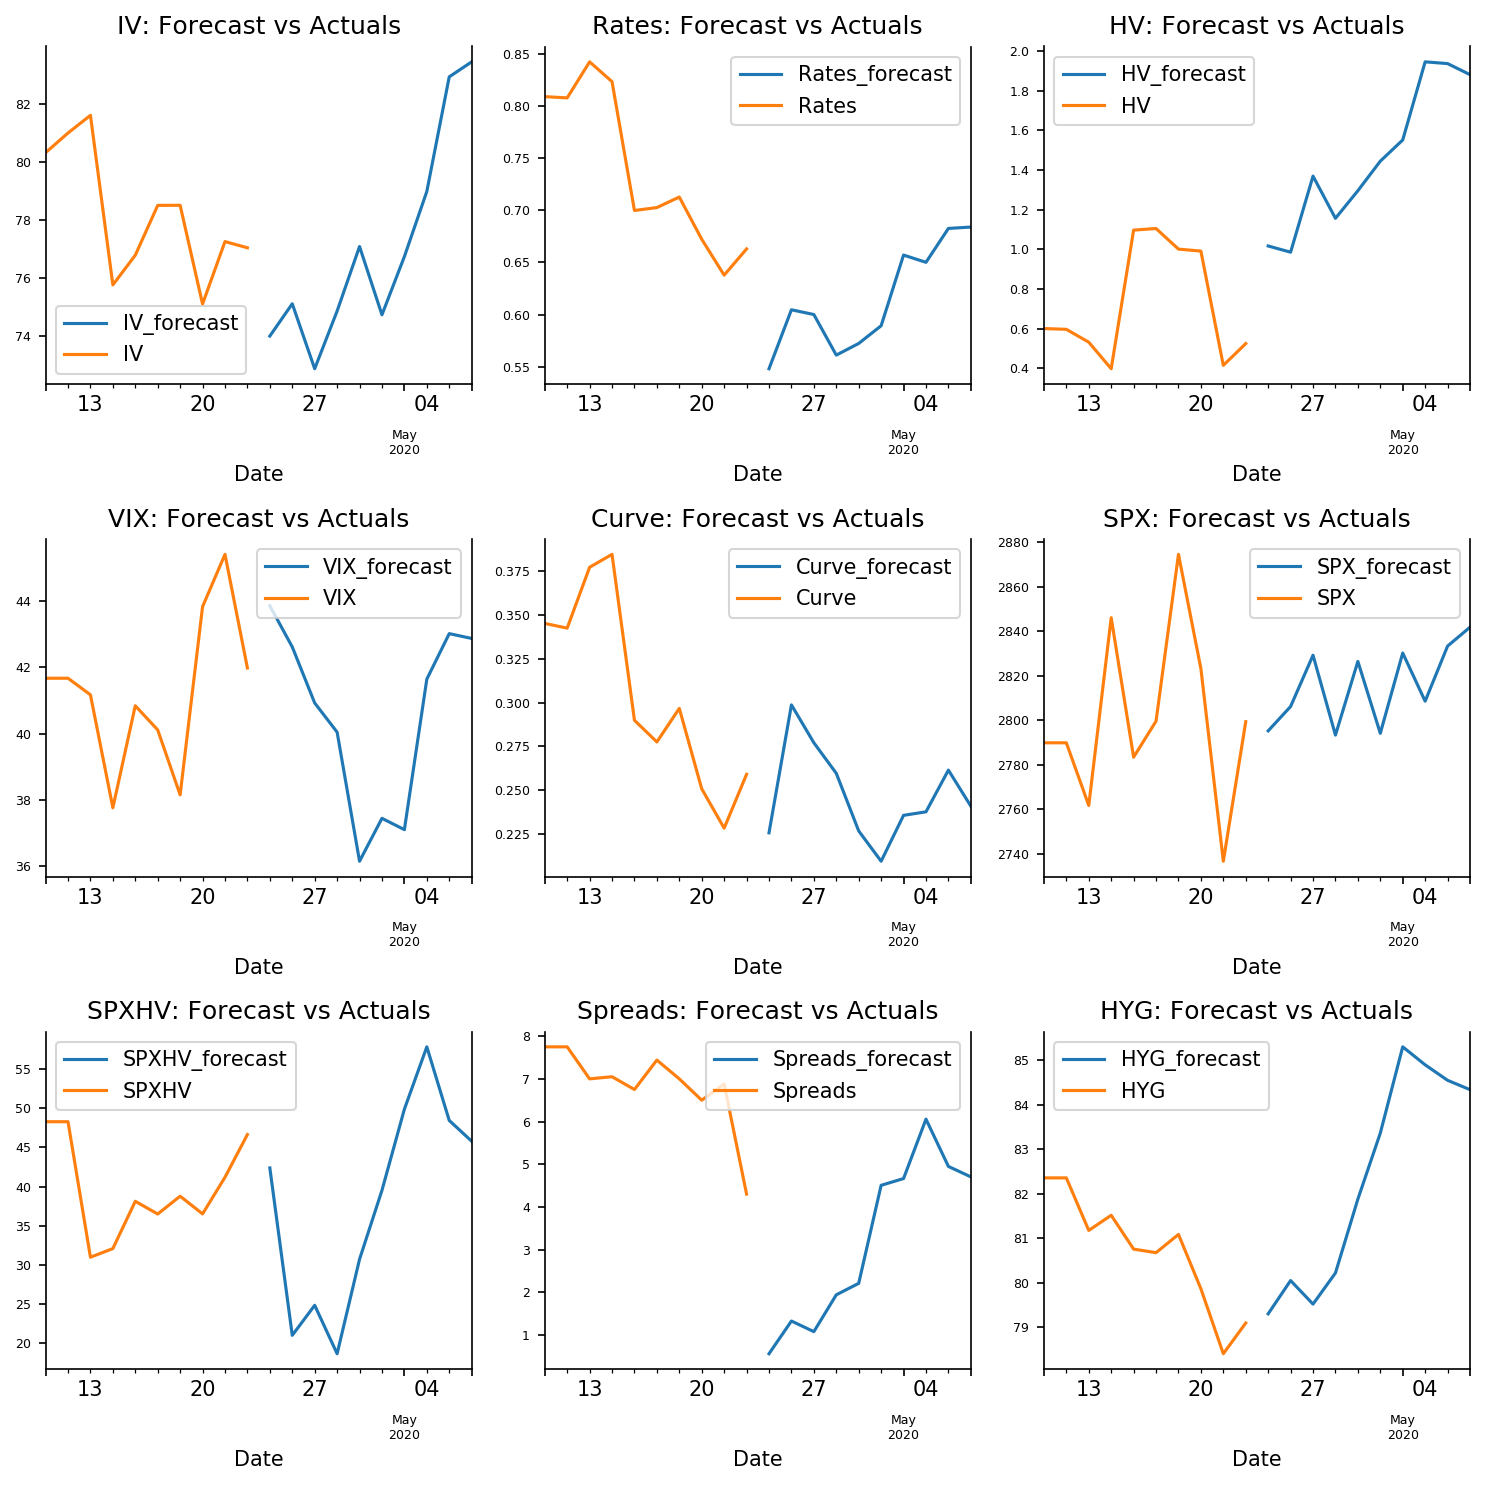

In [54]:
fig, axes = plt.subplots(nrows=int(len(df.columns)/3), ncols=3, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();